# import funcs and load data

In [ ]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 20
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["font.size"] = 10
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

In [ ]:
import importlib
#importlib.reload(sys.modules['load_data'])

path = '/home/theospira/notebooks/projects/WW_climatology'

import sys
sys.path.append(path+'/functions')
from plot_formatting import *
from inspection_funcs import boxplot
from smoothing_and_interp import *

from load_data import load_data
# load data
#ds, ds_s, ds_ww, bth, ssh, si, szn = load_data(path+'/data/hydrographic_profiles/SO_1yr_clim_seasonal.nc')
ds, ds_s, ds_ww, bth, ssh, si, szn = load_data(path+'/data/hydrographic_profiles/superseded/SO_1yr_clim_seasonal-preDec23.nc')

In [ ]:
alphbt = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
          'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# $$\frac{\delta \, T_{WW}}{\delta t} = \frac{\delta}{\delta t} \int^{thickness} \Theta \, \delta z$$

# WW heat budget, adapting Giddy et al (2023):

# $$\frac{\delta \, Q_{WW}}{\delta t} = \Delta Q_{SW} + Q_{mixing} + Q_{entrainment} + Q_{subduction/erosion} + Q_{residual}$$

## $Q_{mixing}$ and $Q_{entrainment}$ are comprised of upper and bottom boundary components. Residual includes advection, other internal mixing (background flow etc).subduction of WW is included in a second version below.

## $$\begin{aligned}
\text{(I)}\quad \frac{{\delta T_{WW}}}{{\delta t}} = & \frac{{\Delta Q_{SW}}}{{\rho_0 C_p}} && \text{(II)} \\
& + \frac{1}{{h_{WW}}}\left[ \left( -K\frac{{\delta T}}{{\delta z}} \right) _{h_{ML}} - \left(-K_{DDC}\frac{{\delta T}}{{\delta z}}\right) _{h_{WW}}\right] && \text{(III)} \\
& + \frac{H}{{h_{WW}}}w_{e_{ub}}\Delta T_{ML-WW} + \frac{H}{{h_{WW}}}w_{e_{lb}}\Delta T_{WW-CDW} && \text{(IV)} \\
& + T_{\text{creation/erosion}} && \text{(V)} \\
& + T_{\text{residual}} && \text{(VI)}
\end{aligned}$$

iss's heat budget:
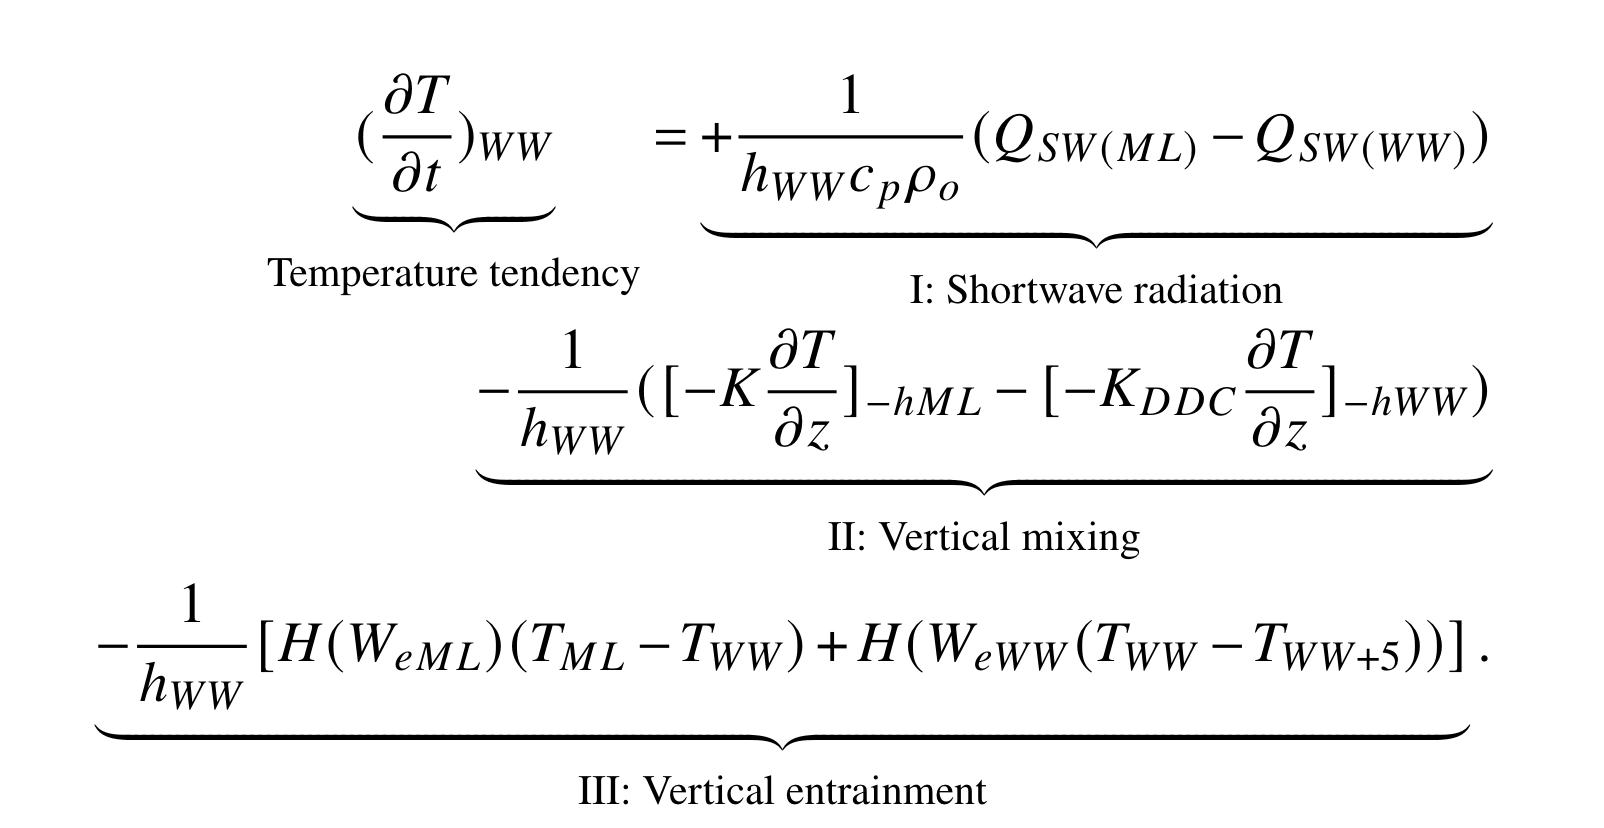

# WW heat budget, adapting Giddy et al (2023): $$\frac{\delta \, Q_{WW}}{\delta t} = \Delta Q_{SW} + Q_{mixing} + Q_{entrainment} + Q_{subduction/erosion} + Q_{residual}$$

## $Q_{mixing}$ and $Q_{entrainment}$ are comprised of upper and bottom boundary components. Residual includes advection, other internal mixing (background flow etc).subduction of WW is included in a second version below.

## $$\begin{aligned}
\text{(I)}\quad \frac{{\delta T_{WW}}}{{\delta t}} = & \frac{1}{{h_{WW}}}\frac{{\Delta Q_{SW}}}{{\rho_0 C_p}} && \text{(II)} \\
& + \frac{1}{{h_{WW}}} \left( -K\frac{{\delta T}}{{\delta z}} \right) _{h_{ML}} && \text{(III)} \\
& + \frac{H}{{h_{WW}}}w_{e_{ub}}\Delta T_{ML-WW} + \frac{H}{{h_{WW}}}w_{e_{lb}}\Delta T_{WW-CDW} && \text{(IV)} \\
& + T_{\text{creation/erosion}} && \text{(V)} \\
& + T_{\text{residual}} && \text{(VI)}
\end{aligned}$$

# Term 1: shortwave penetrative flux

## shortwave penetrative flux, $Q_{SW}$, is approximated by expenential decay of Q_SW for Jerlov Type II waters where chla a > 0.01 mg m-3 such that: $$R_s\left( z \right) = R_s\left( 0 \right) \left[ 0.77 exp\left(\frac{-\vert z \vert}{1.4}\right) + 0.23exp\left(\frac{-\vert z \vert}{14}\right)\right]$$

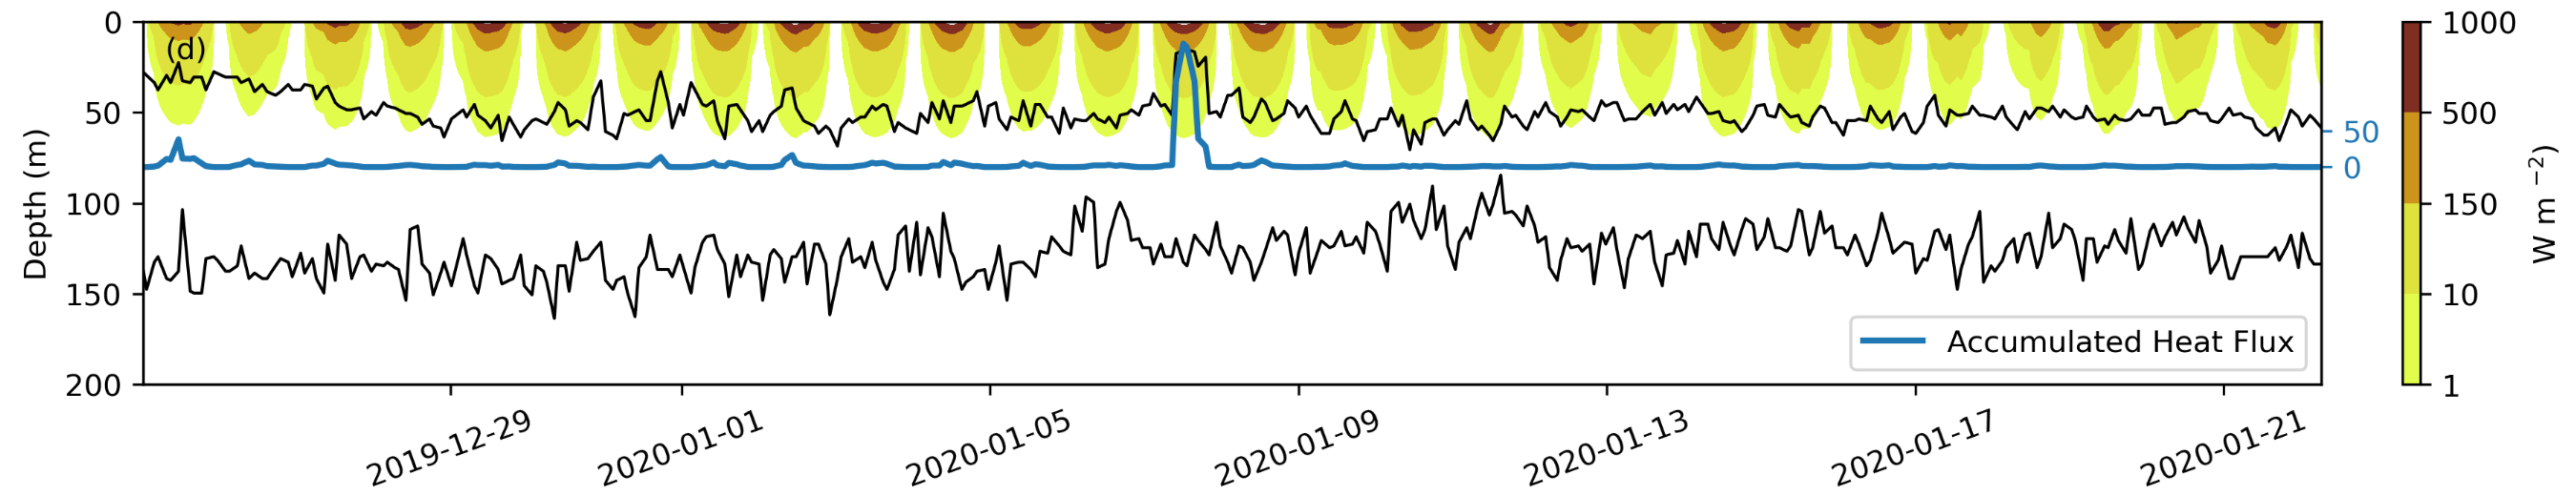
term 2 (panel b)! ↓ 
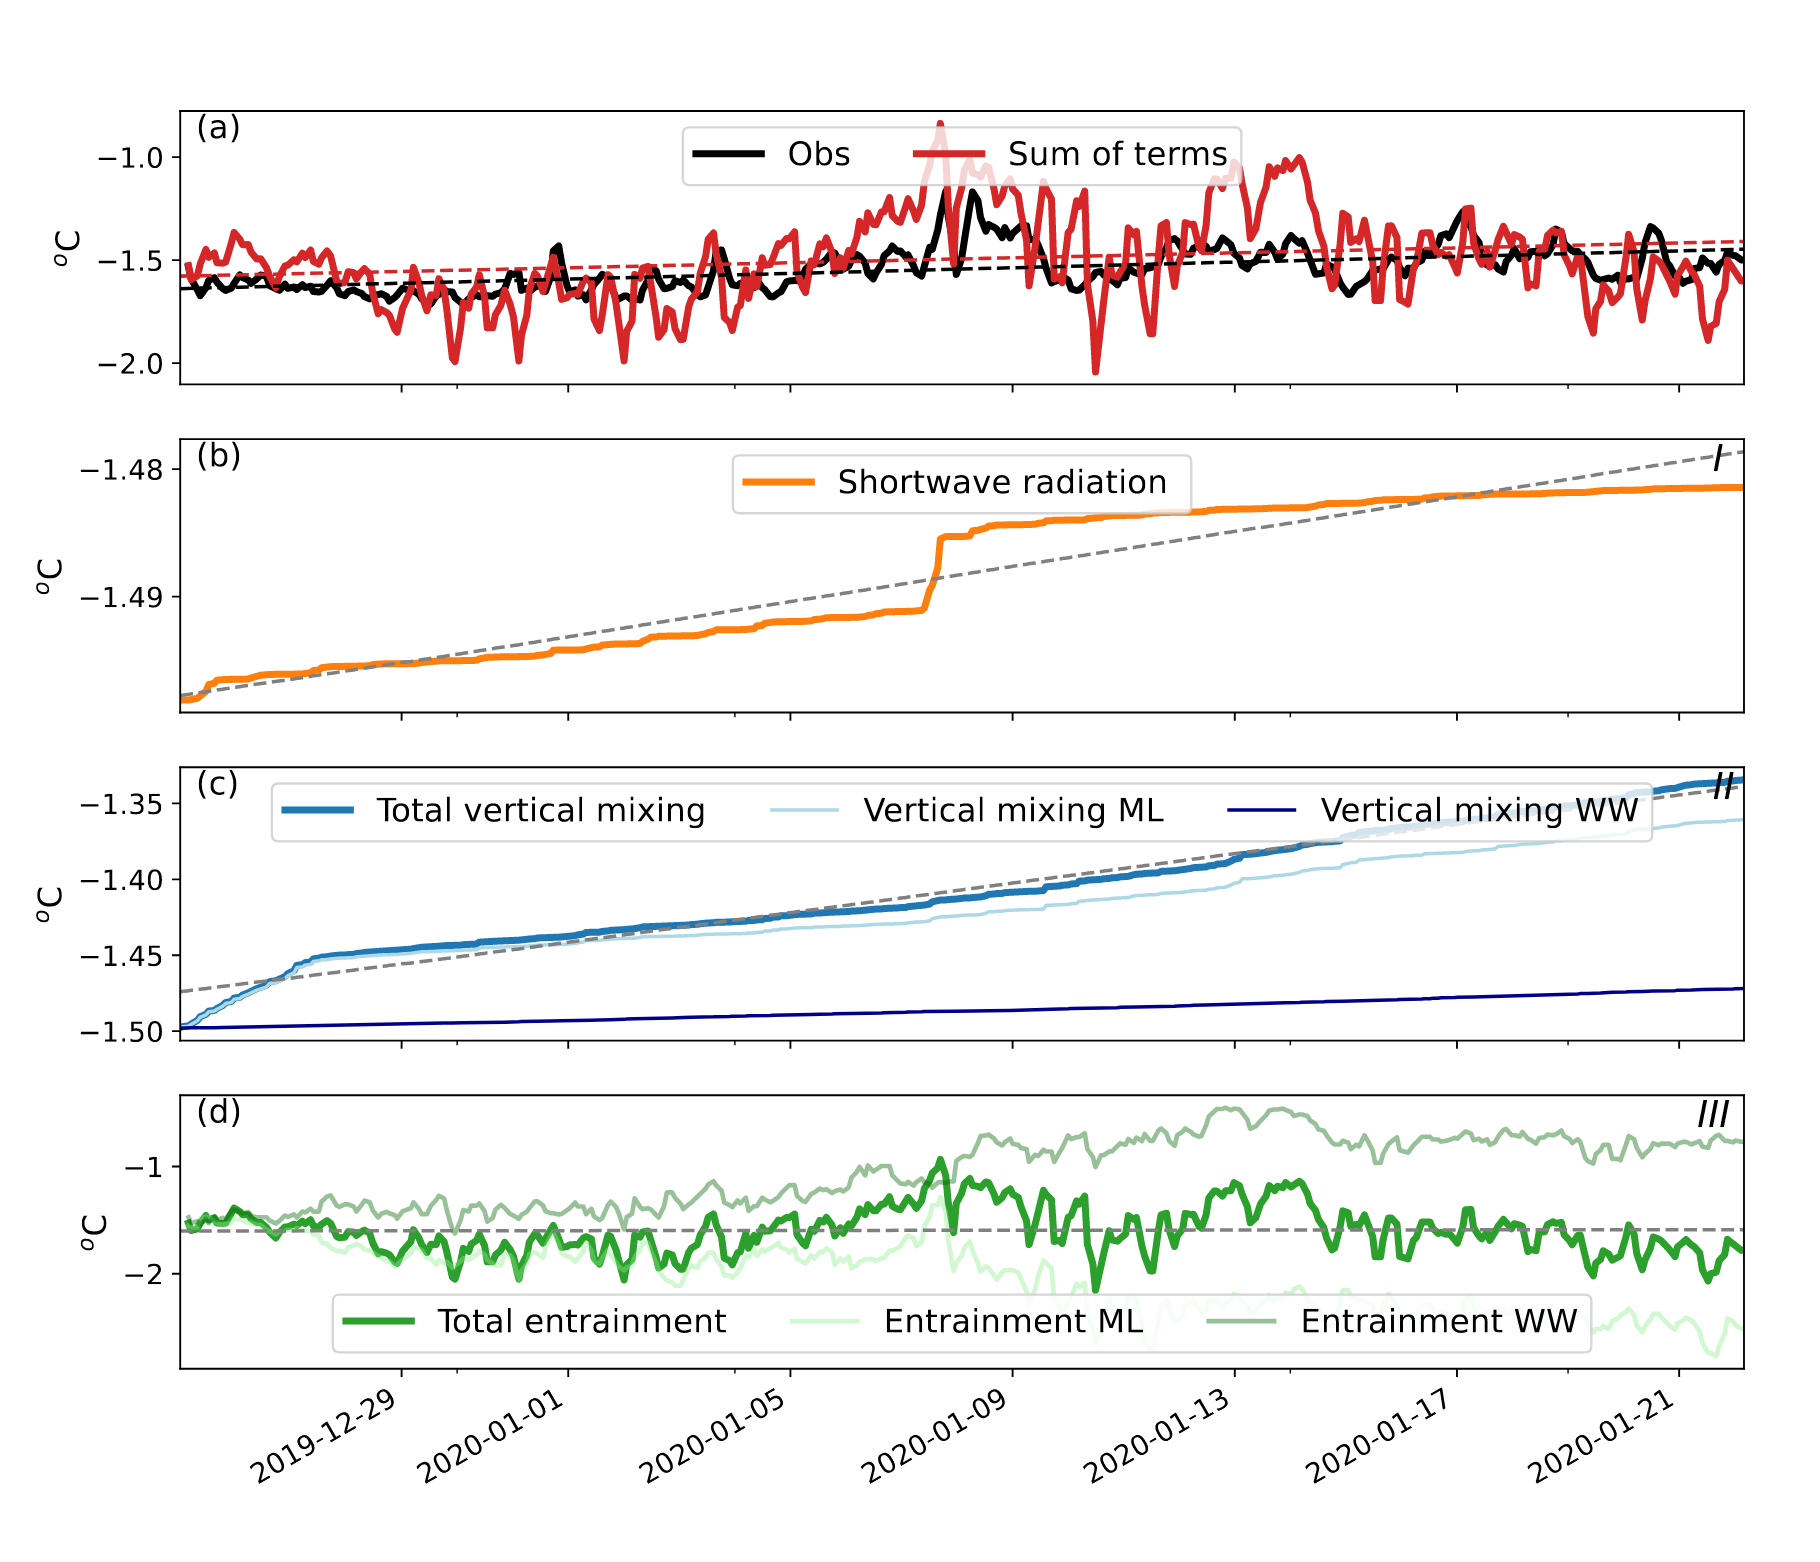

In [ ]:
def ww_qsw_calcs(ds):
    
    # open SW heat flux data
    tmp = xr.open_mfdataset('/home/theospira/notebooks/data/ERA5/heat_flux/monthly/*.nc'
                ).ssr.groupby_bins('time.month',bins=range(0,15,3),labels=range(0,4)).mean().load(
                    ).sel(latitude=slice(-40,-79)
                        ).transpose('month_bins','longitude','latitude').sortby('latitude') / (3600 * 24)
                            # divide by time as per era5 documentation. this gets to per day

    ssr = np.ndarray(ds.mld.shape) * np.nan
    for i in range(4):
        # mean SW per season
        # sorted in order of Wtr,Spr,Sum,Aut
        ssr[int((i+2)%4)] = tmp[i].data

    ds['ssr'] = xr.DataArray(ssr,dims=('season','lon','lat'))
    
    #### calc Q_sw ####
    sw_ww = np.ndarray(ds.mld.shape) * np.nan
    lb    = ds.lw_bd.data
    ub    = ds.up_bd.data
    condn = np.logical_and(~np.isnan(lb),~np.isnan(ub))
    ssr   = ds.ssr.data

    for t in tqdm(range(4)):
        for i in range(360):
            for j in range(40):
                if condn[t,i,j]:
                    # determine upper and lower boundary SW values
                    sw_ub = ssr[t,i,j] * (0.77 * np.exp(- np.abs(ub[t,i,j] / 1.4
                                                        ) + 0.23 * np.exp(- np.abs(ub[t,i,j])/14)))
                    sw_lb = ssr[t,i,j] * (0.77 * np.exp(- np.abs(lb[t,i,j] / 1.4
                                                        ) + 0.23 * np.exp(- np.abs(lb[t,i,j])/14)))
                    # => total SW absorbed by WW is difference
                    sw_ww[t,i,j] = sw_ub - sw_lb

    # density and spec heat capacity of seawater
    r,c = 1035,3850
    # SW data is across each grid cell so we normalise by area to get mean SW per 1m2
    ds['Q_sw'] = xr.DataArray(sw_ww,dims=('season','lon','lat')) # / (r * c)  # (ds.area * r * c) 
    
    return ds

In [ ]:
ds = ww_qsw_calcs(ds)

In [ ]:
(ds.sw_ww).plot(row='season',x='lon',cmap='cmo.solar',figsize=(12,7),vmin=0,vmax=3e-9)

# term 2: mixing

## calculate bulk density ratio: $$R_{\rho} = \frac{\alpha \frac{\delta T}{\delta z}}{\beta \frac{\delta S}{\delta z}}$$

In [ ]:
def calc_R(ds):
    a_b = np.ndarray(ds.ctemp.shape) * np.nan 
    a = np.ndarray(ds.ctemp.shape) * np.nan 


    # turner angle is a depth differential, so 1 less in pres col
    for i in tqdm(range(4)):
        for j in range(360):
            for k in range(40):
                a_b[i,j,k,:] = gsw.alpha_on_beta(ds.asal[i,j,k,:],ds.ctemp[i,j,k,:],ds.pres)[0]
                a[i,j,k,:]   = gsw.alpha_on_beta(ds.asal[i,j,k,:],ds.ctemp[i,j,k,:],ds.pres)[0]

    ds['a_b'] = xr.DataArray(a_b,dims=('season','lon','lat','pres'))
    ds['a']   = xr.DataArray(a,  dims=('season','lon','lat','pres'))

    # calculate density ration across water column
    ds['R'] = ds.a_b * ds.ctemp.diff('pres') / ds.asal.diff('pres')

    return ds

def calc_R_ub(ds):
    R_ub = np.ndarray(ds.ww_ct.shape) * np.nan
    ub = ds.up_bd

    for i in tqdm(range(4)):
        for j in range(360):
            for k in range(40):
                if ~np.isnan(ub[i,j,k]) and int(ub[i,j,k]/2) < 145:
                    ub_idx = int(ub[i,j,k]/2)
                    R_ub[i,j,k] = ds.R.isel(season=i,pres=slice(ub_idx-8,ub_idx+8),lon=j,lat=k).mean('pres')

    ds['R_ub'] = xr.DataArray(R_ub,dims=('season','lon','lat'))
    
    return ds

In [ ]:
ds = calc_R(ds)
ds = calc_R_ub(ds)

## ML mixing calcs

#### check upper boundary density ratio for type of mixing

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = ds.R_ub.where(ds.ww_type!=np.logical_or(1,2)).isel(season=i).plot(
                        x='lon',transform=crs,vmin=-1,vmax=1.25,cmap='cmo.tarn',levels=12,
                        ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label='upper boundary R',fontsize=fs)
cb.set_ticks(np.append(np.arange(-1,1.5,0.5),1.1))
cb.set_ticklabels(['-1','Stable','0','DC','1','SF'])

ie, upper boundary is dominantly display a stable regime within the water column with "warm" and fresh water overlying cold and saline water.

### $\kappa_{ML}$ can be obtained through law of the wall.

### mixed layer friction velocity and theoretical dissipation: $$u_* = \sqrt{\frac{\tau}{\rho_{sw}}} \text{ and } \varepsilon = \frac{u_*^3}{kz}$$ where $k=0.41$ is von Karman's constant and z is the WW upper boundary depth. $\rho_0 = 1035$? (Nicholson et al 2022, following Large and Pond 1981 and Lombardo and Gregg 1989).
### Diapycnal diffusivity, K, is given by $$K = \Gamma \frac{\varepsilon}{N^2}$$ where we can take $\Gamma = 0.2$ as a constant at its upper limit (Osborn 1980). This can then be used to find a vertical turbulent heat and sal flux: $$Q_h = -\rho C_p \kappa_{\rho}T_z \text{ and } Q_S = \frac{- \rho C_p \kappa_{\rho}T_z}{1000}$$

### We use this under the form of: $$Q_h = -\rho C_p K \, T_z$$

Friction velocity, $u_*$, is the velocity scale scale to represent shear at a boundary. It is based on the bed stress such that $\tau_{bed} = \rho u_*^2$. This velocity characterises the turbulence strength and laminar sub-layer thickness (ie, mixing layer!)

In [ ]:
# open wind stress
ws = xr.open_dataset('/home/theospira/notebooks/data/ERA5/winds/wind_stress/tau_seasonal_mean_2004-2021.nc'
                    ).sortby('lat')
#ws

In [ ]:
# calculate the area for each grid cell
from geopy.distance import geodesic

def calc_epsilon(ds,ws):

    d_x = np.ndarray([40,360])*np.nan
    d_y = np.ndarray([40,360])*np.nan
    for i in range(40):
        for j in range(360):
            # calculate distance between each lon point
            d_x[i,j] = geodesic((-79+i, -180 + j),         # coord1: lat, lon
                                (-79+i, -180 + (j+1))      # coord2
                                ).km * 1000

            # calculate distance between each lat point
            d_y[i,j] = geodesic((-79+i,     -180 + j),      # coord1: lat, lon
                                (-79+i + 1, -180 + j)       # coord2
                                ).km * 1000

    ds['area'] = xr.DataArray(d_x * d_y,dims={'lat':ds.lat,'lon':ds.lon})


    # calc tau and ε
    r,k = 1035,0.41   # density and von Karman const

    ws['tau'] = np.sqrt(ws.ewss**2 + ws.nsss**2) # get magnitude of tau and divide by area of grid cell to get mean windstress over cell

    ws['e_ml'] = np.sqrt(ws.tau/r # calculate u*
                           )**3 / (k * ds.where(ds.ww_type==2).up_bd) / ds.area # calc epsilon. only use subsurf WW 
    
    return ds,ws

In [ ]:
r,c = 1035,3850

def mixing_ub(ds,ws):
    """
    calculate the diapycnal diffusivity, K_ub, temperature gradient, ∆T (following Cronin et al (2015)), and quantify temperature tendency of mixing, mx_ub, at the upper boundary.
    
    follows law of the wall, using frictional velocity for theoretical dissipation, ε, calculated from u_* via wind stress (following Nicholson et al (2022)).
    
    input hydrographic profiles dataset, ds, wind stress dataset, ws. returns updated ds with new variables.
    
    """
    
    n2_ub = np.ndarray(ds.ww_ct.shape) * np.nan
    n2    = ds.n2
    up_bd = ds.up_bd.data
    condn = ~np.isnan(ds.where(ds.ww_type==2).ww_type.data) 
    # assign
    for i in tqdm(range(360),"calc n2"):
        for j in range(40):
            for k in range(4):
                if condn[k,i,j]:
                    n2_ub[k,i,j] = ds.n2.isel(season=k,lon=i,lat=j).sel(pres=slice(up_bd[k,i,j]-10,up_bd[k,i,j]+10)
                                        ).mean(skipna=True).data

    ds['n2_ub'] = xr.DataArray(n2_ub,
                                  dims   = {'season':ds.season.data,
                                            'lon':ds.lon.data,'lat':ds.lat.data},
                                  coords = {'season':ds.season.data,
                                            'lon':ds.lon.data,'lat':ds.lat.data},)

    # calculate diapycnal diffusivity at ML $K_{ML}$
    gm = 0.2 # gamma
    ds['K_ub'] = gm * ws.e_ml / ds.n2_ub

    #######################

    # calculate ∆T across upper boundary to determine mixing rate. 
    # approximate using  mean mld and ww core temp for largest gradient of T
    ub      = ds.up_bd.where(ds.ww_type==2).data
    delta_T = np.ndarray(ds.mld.shape) * np.nan

    for t in tqdm(range(4),"calc ∆T"):
        for i in range(360):
            for j in range(40):
                if ~np.isnan(ub[t,i,j]):
                    # get the T above and below the WW-CDW interface
                    T_abv = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=slice(0,ub[t,i,j])).mean('pres',skipna=True).values 
                    # Cronin et al (2015) use 20m below MLD for ∆T. 
                    # they investigate in the N Pacific. Maybe not directly comparable? Not such high lats.
                    T_blw = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=ub[t,i,j]+20,method='nearest').values 

                    if T_abv - T_blw > 0:
                        delta_T[t,i,j] = T_abv - T_blw

    ds['delta_T_ub'] = xr.DataArray(delta_T,dims=('season','lon','lat'))
    #ds['delta_T_ml'] = ds.delta_T_ml.where(ds.delta_T_ml>0,np.nan)

    
    r,c = 1035,3850 # density and spec heat cap
    ds['F_mx_ub'] = ds.delta_T_ub * ds.K_ub.where(ds.K_ub>0) *r*c #.transpose('season','lon','lat')
    
    return ds

In [ ]:
# calc avg number of seconds per season 

def season_to_seconds():
    
    # there are 5 leap years from 2004-21. Adjust for this when taking mean
    # take days for whole period and convert into seconds then take mean second per season (/18)
    # https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview
    # the above says "This parameter is accumulated over a particular time period which depends on the data extracted. 
    # For the monthly averaged reanalysis and the monthly averaged ensemble members, the accumulation period is 1 day."

    tm = xr.DataArray(pd.date_range('01-01-2004','31-12-2021',freq='1d'),dims='time' 
                    ).groupby_bins('time.month',bins=range(0,15,3),labels=range(0,4)) # group into seasons

    szn_scs = np.ndarray(ds.mld.shape) * np.nan
    for i in range(4):
        # mean number of seconds per season
        # sorted in order of Wtr,Spr,Sum,Aut
        szn_scs[int((i+2)%4),:,:] = tm[i].time.size * 24 * 60 * 60 / 18 
        
    return szn_scs

In [ ]:
ds,ws = calc_epsilon(ds,ws)
ds    = mixing_ub(ds,ws)

# remove any unrealistic data points (ie, greater than 60 Wm-2)
ds['F_mx_ub'] = ds.F_mx_ub.where(ds.F_mx_ub.__abs__()<60)

# make sure mixing for upper boundary is confined to ice free zone, where wind interacts with ocean surface
# note: there is still a stress applied to ocean surf but we don't know the relation!!!
ice = (ds.sic - 15).__abs__().idxmin(dim='lat')
ds['F_mx_ub'] = ds.F_mx_ub.where(ds.F_mx_ub.lat>ice)


# there are 5 leap years from 2004-21. Adjust for this when taking mean
# take days for whole period and convert into seconds then take mean second per season (/17)
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview
# the above says "This parameter is accumulated over a particular time period which depends on the data extracted. 
# For the monthly averaged reanalysis and the monthly averaged ensemble members, the accumulation period is 1 day."
szn_scs = season_to_seconds()

In [ ]:
crs = ccrs.PlateCarree()
vmax=60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

fig,ax = plt.subplots(1,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax = ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,si=si)

for i,a in enumerate(ax):
    hmp = ds.F_mx_ub.where(ds.F_mx_ub.lat>ice)[i].plot(**kwargs,ax=a,)
    a.set_title(szn[i])
    
fig.colorbar(hmp,ax=ax[-1],shrink=0.3,aspect=12,extend='both')

#### brief check

In [ ]:
boxplot(ds.delta_T_ub,showfliers=False)

In [ ]:
c = 3850 # specific heat capacity of sea water, Talley lec notes

boxplot(ds.F_mx_ub,showfliers=False)

ax = (ds.F_mx_ub).plot(row='season',x='lon',figsize=(12,7),vmin=0,vmax=30,cmap='cmo.amp',) #levels=5)
ax.cbar.set_label('$Q_{ML}$ W m$^{-2}$')

In [ ]:
(ds.F_mx_ub).sel(lat=slice(-61,-58),lon=0)

In [ ]:
(ds.F_mx_ub).sel(lat=slice(-61,-58),lon=0)[2].mean()

In [ ]:
boxplot(np.log10(ds.K_ub))

In [ ]:
boxplot(np.log10(ds.K_ub[2]))

pretty happy with the above. roughly lines up with Iss's findings around (0°E,60°S). She found an avg of 15 Wm-2 from ML mixing across Jan. My findings are lower in that region, but that is to be expected since it is across a 3 month period and not an instantaneous result, but a climatological finding. Likely Jan has largest ∆T in that period => larger Q

#### plot

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
    
kwargs = dict(x='lon',transform=crs,add_colorbar=False,)

for i,a in enumerate(ax[:4]):
    hmp = (ds.delta_T_ub).isel(season=i
                    ).plot(**kwargs,vmin=0,vmax=1.5,cmap='cmo.thermal',ax=a)#levels=5)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'∆T (°C dbar$^{-1}$)',fontsize=fs)

for i,a in enumerate(ax[4:8]):
    hmp = (ds.K_ub*1e5).isel(season=i
                    ).plot(**kwargs,vmin=0,vmax=2,cmap='cmo.amp',ax=a,)#levels=5)
    
    a.set_title('')
cb = fig.colorbar(hmp,ax=ax[4:8],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'$K_{ML} \times 10^{-5}\,m^2 s^{-1}$',fontsize=fs)

for i,a in enumerate(ax[8:12]):
    hmp = (ds.n2_ub*1e5).isel(season=i
                    ).plot(**kwargs,vmin=0,vmax=5,cmap='Blues',ax=a,)#levels=5)
    
    a.set_title('')
cb = fig.colorbar(hmp,ax=ax[8:12],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'$N^2_{ub} \times 10^{-5}\,m^2 s^{-1}$',fontsize=fs)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
  #  b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
   #                                  colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
for i,a in enumerate(ax[:4]):
    hmp = (ds.F_mx_ub).isel(season=i
                    ).plot(x='lon',transform=crs,vmin=0,vmax=60,cmap='cmo.amp',ax=a,add_colorbar=False,)#levels=5)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'ML mixing (°C dbar szn$^{-1}$)',fontsize=fs)

fig.suptitle('Seasonally & depth integrated ML \n boundary mixing, $K_{ML} \cdot \delta_z T $')

This is heat entering the WW system. Note i think overestimated using K_ml from u* - check this!

## WW-CDW interface (mixing -- dont run!!!)

### following Shibley et al, calculate bulk density ratio: $$\overline{R_{\rho}} = \frac{\alpha \Delta T}{\beta \Delta S}$$ where $\Delta T$ and $\Delta S$ are taken as difference of T,S at WW core and lower bound, whilst $\alpha$ and $\beta$ are taken at mid-depth between lb and core.

In [ ]:
# calculate bulk density ratio of lower bound following Shibley et al 2017 - arctic paper
# instead of using properies 50m above lower boundary, we use core T,S and lb properties
# we use mid depth between lb and cp for alpha and beta (following Shibley et al 2017)

def calc_R_lb(ds):

    a_b  = np.ndarray(ds.ww_ct.shape) * np.nan
    a    = np.ndarray(ds.ww_ct.shape) * np.nan
    b    = np.ndarray(ds.ww_ct.shape) * np.nan
    R_lb = np.ndarray(ds.ww_ct.shape) * np.nan
    lb   = ds.lw_bd

    for i in tqdm(range(4)):
        for j in range(360):
            for k in range(40):
                if ~np.isnan(lb[i,j,k]) and int(lb[i,j,k]/2) < 145:
                    lb_idx = int(lb[i,j,k]/2)

                    # calculate T,S gradients
                    dT = ds.ww_ct[i,j,k] - ds.ctemp[i,lb_idx,j,k]
                    dS = ds.ww_sa[i,j,k] - ds.asal[ i,lb_idx,j,k]

                    # calc mid depth alpha_beta
                    p_mid = (lb[i,j,k] - ds.ww_cd[i,j,k])/2
                    p_mid = lb[i,j,k]  - p_mid
                    a_b[i,j,k] = gsw.alpha_on_beta(ds.asal[i,:,j,k],ds.ctemp[i,:,j,k],p_mid)[0]
                    a[i,j,k]   = gsw.alpha(ds.asal[i,:,j,k],ds.ctemp[i,:,j,k],p_mid)[0]
                    b[i,j,k]   = gsw.beta( ds.asal[i,:,j,k],ds.ctemp[i,:,j,k],p_mid)[0]

                    # bulk density ratio for lower bound
                    R_lb[i,j,k] = a_b[i,j,k]*dT/dS

    # calculate bulk density ratio
    ds['R_lb'] = xr.DataArray(R_lb,dims=('season','lon','lat'))
    ds['a_lb'] = xr.DataArray(a,dims=('season','lon','lat'))
    ds['b_lb'] = xr.DataArray(b,dims=('season','lon','lat'))
    
    return ds

In [ ]:
ds = calc_R_lb(ds)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = ds.R_lb.where(ds.ww_type==2).isel(season=i).plot(
                        x='lon',transform=crs,vmin=-1,vmax=1,cmap='cmo.tarn',levels=12,
                        ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'lower boundary $\overline{R_{\rho}}$',fontsize=fs)
cb.set_ticks(np.append(np.arange(-1,1.5,0.5),1.1))
cb.set_ticklabels(['-1','Stable','0','DC','1','SF'])

therefore diffusive convection processes are feasible at the WW-CDW interface. we make the assumption that diffusive convective mechanisms ARE taking place, and parameterise them as follows.

### we now use the following paramterisation to estimate the rate of diffusive mixing (4/3 flux law, Kelley 1990 & Turner 1967), as per van det Boog et al (2021): 
### $$K_T^{DC}=\exp\left(\frac{4.8}{R_{\rho}^{-0.72}}\right)\left(\frac{\alpha g \kappa}{\text{Pr}} \right)^{\frac{1}{3}}\left(\Delta T_{IF}\right)^{\frac{4}{3}}\left(\frac{\delta T}{\delta z} \right)^{-1}$$
**_Note:_** it is unclear where the $\left(\frac{\delta T}{\delta z} \right)^{-1}$ term is derived from. Hence, we opt not to use this form of the flux equation.
### However, we use the same as Shibley et al (2017) and Iss, applying the empirical flux law (Kelley 1990): $$F_{4/3}=0.0032 \, \exp\left(\frac{4.8}{R_{\rho}^{0.72}}\right)\rho C_p\left(\frac{\alpha g \kappa}{\text{Pr}} \right)^{\frac{1}{3}}\left(\Delta T_{IF}\right)^{\frac{4}{3}}$$

### where the Prandtl number assumes only the temperature jump across a double diffusive interface is resolved such that:
### $$\text{Pr}=\frac{\nu}{\kappa} = \frac{\text{kinematic viscosity}}{\text{molecular diffusivity}} = \frac{1.4 \times 10^{-7}\text{ m s}^{-1}}{1.8 \times 10^{-6}\text{ m s}^{-1}}$$ 
### $\Delta T_{IF}$ is the difference in temperature at the interface. $\delta_z T$ is the vertical gradients of conservative temperature using a central differences scheme across a smoothed profile. This has been implemented in multiple studies, including van der Boog et al (2021) and Shibley et al (2017) (Arctic focus).

#### following shibley et al 

In [ ]:
r,c = 1035,3850

delta_T = np.ndarray(ds.R_lb.shape) * np.nan
dT      = np.ndarray(ds.R_lb.shape) * np.nan
a_lb    = np.ndarray(ds.R_lb.shape) * np.nan
lb      = ds.lw_bd.where(ds.ww_type==2)
condn   = np.logical_and(~np.isnan(lb),np.logical_and(0<ds.R_lb,ds.R_lb<1))

for t in tqdm(range(4)):
    for i in range(360):
        for j in range(40):
            if condn[t,i,j]:
                
        ######## alternative calc for ∆T ###############
                # get the T above and below the WW-CDW interface
                # taken as ±5dbar since scales of DC are small
                      
              #  T_abv = ds.ww_ct.isel(season=t,lon=i,lat=j).values 
                
#                if T_blw - T_abv > 0:
 #                   delta_T[t,i,j] = T_blw - T_abv
        ######## alternative calc for ∆T ::  end ###############
    
    
                # mean temp difference between adjacent layers ±5dbar about the WW-CDW interface
                dT[t,i,j] = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=slice(lb[t,i,j]-5,lb[t,i,j]+5)
                                            ).diff('pres').mean('pres',skipna=True).values
                
                # calculate ∆T
                T_abv = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=lb[t,i,j]-5,method='nearest').values 
                T_blw = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=lb[t,i,j]+5,method='nearest').values 
                
                if T_blw - T_abv > 0:
                    delta_T[t,i,j] = T_blw - T_abv
                
                a_lb[t,i,j] = ds.a.isel(season=t,lon=i,lat=j).sel(pres=slice(lb[t,i,j]-5,lb[t,i,j]+5)
                                                                    ).mean('pres',skipna=True).values

# calculate heat flux following 4/3 flux law at the lower boundary
nu,kap = 1.4e-7, 1.8e-6  # Shibley et al (2017)
g = 9.8

# Shibley's eqn (2017). Iss also follows this eqn.
ds['F_mx_lb'] = xr.DataArray(0.0032 * np.exp(4.8 / (ds.R_lb.where(np.logical_and(0<ds.R_lb,ds.R_lb<1))**(0.72))
                                            ) * (a_lb * g * kap / (nu/kap))**(1/3) * dT**(4/3) * r * c,
                             dims   = {'season':ds.season.data,'lon':ds.lon.data,'lat':ds.lat.data},
                             coords = {'season':ds.season.data,'lon':ds.lon.data,'lat':ds.lat.data},)

#### check this calc

In [ ]:
boxplot((ds.F_mx_lb),showfliers=False) 

In [ ]:
ds.F_mx_lb.plot(row='season',x='lon',figsize=(12,7),vmin=0,vmax=1e6,cmap='cmo.amp')

In [ ]:
ds['t1'] = xr.DataArray(0.0032 * np.exp(4.8 / (ds.R_lb.where(np.logical_and(0<ds.R_lb,ds.R_lb<1))**(0.72))), dims=('season','lon','lat'))
ds['t2'] = xr.DataArray((a_lb * g * kap / (nu/kap))**(1/3) , dims=('season','lon','lat'))
ds['t3'] = xr.DataArray(dT**(4/3), dims=('season','lon','lat'))

In [ ]:
#for v in ['t1','t2','t3']  print(ds[v].mean())

for v in ['t1','t2','t3']:
    print(np.isfinite(ds[v]).sum().data)

In [ ]:
#for v in ['t1','t2','t3']  print(ds[v].mean())

for v in ['t1','t2','t3']:
    print(v)
    boxplot(ds[v],showfliers=False)
    plt.show()

In [ ]:
(ds.t1 * ds.t2 * ds.t3).plot(row='season',x='lon',vmin=0,vmax=1500, cmap='cmo.amp',figsize=(12,10),)

In [ ]:
(ds.F_mx_lb.where(ds.F_mx_lb<100e3)).plot(row='season',x='lon',vmin=0,vmax=100, cmap='cmo.amp',figsize=(12,10),)

In [ ]:
print('1/R_lb^-0.72 term')
(ds.t1).plot(row='season',x='lon',vmin=0,vmax=1500, cmap='cmo.amp',figsize=(12,10),)
plt.show()
print('alpha term')
(ds.t2).plot(row='season',x='lon',vmin=0.02,vmax=0.035, cmap='cmo.amp',figsize=(12,10),)
plt.show()
print('∆T**4/3 term')
(ds.t3).plot(row='season',x='lon',vmin=0,vmax=0.5, cmap='cmo.amp',figsize=(12,10),)
plt.show()

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice, front contours and bathym
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
for i,a in enumerate(ax[:4]):
    hmp = (ds.F_mx_lb * 1e-3).isel(season=i
                    ).plot(x='lon',transform=crs,vmin=0,vmax=500,cmap='cmo.amp',ax=a,add_colorbar=False,)#levels=5)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'$\times 10^6$ W m$^{-2}$',fontsize=fs)

fig.suptitle('WW-CDW mixing, $F_{4/3}$')

idk lol this one is not right

### show incorrect F_lb, following van der Boog such that the equation is for a diffusivity and then multiply by delta T of staircases

In [ ]:
delta_T = np.ndarray(ds.R_lb.shape) * np.nan
dT      = np.ndarray(ds.R_lb.shape) * np.nan

for t in tqdm(range(4)):
    for i in range(360):
        for j in range(40):
            if condn[t,i,j]:
                
        ######## alternative calc for ∆T ###############
                # get the T above and below the WW-CDW interface
                # taken as ±5dbar since scales of DC are small
              #  T_abv = ds.ww_ct.isel(season=t,lon=i,lat=j).values 
                      
                T_abv = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=lb[t,i,j]-5,method='nearest').values 
                T_blw = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=lb[t,i,j]+5,method='nearest').values 
                
                if T_blw - T_abv > 0:
                    delta_T[t,i,j] = T_blw - T_abv
        ######## alternative calc for ∆T ::  end ###############
    
    
                # mean temp difference between adjacent layers ±5dbar about the WW-CDW interface
                dT[t,i,j] = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=slice(lb[t,i,j]-5,lb[t,i,j]+5)
                                            ).diff('pres').mean('pres',skipna=True).values

# remove any negative values of dT
dT[dT<0] = np.nan

#### van der Boog's method with empirical C (0.0032 rather than their ∂T/∂z term)

In [ ]:
# using mean difference of layers
ds['K_lb'] = xr.DataArray(0.0032 * np.exp(4.8 / (ds.R_lb.where(np.logical_and(0<ds.R_lb,ds.R_lb<1))**(-0.72
                                ))) * (a_lb * g * kap / (nu/kap))**(1/3) * dT**(4/3),
                          dims   = {'season':ds.season.data,'lon':ds.lon.data,'lat':ds.lat.data},
                          coords = {'season':ds.season.data,'lon':ds.lon.data,'lat':ds.lat.data},)

# times by ∆T from across interface
ds['F_lb_bad'] = ds.K_lb * dT *r*c

In [ ]:
ds['dT'] = xr.DataArray(dT,dims=('season','lon','lat'))

In [ ]:
boxplot(np.log10(ds.K_lb),showfliers=False)
plt.title('log 10 of K_T')

In [ ]:
boxplot((ds.F_lb_bad),showfliers=False)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice, front contours and bathym
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
                                     colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
for i,a in enumerate(ax[:4]):
    hmp = np.log10(ds.K_lb).isel(season=i
                    ).plot(x='lon',transform=crs,vmin=-5,vmax=-3.5,cmap='Blues',ax=a,add_colorbar=False,) #levels=20)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='max')

fig.suptitle('$K_{T}$')

In [ ]:
chk = dT
chk = chk[np.isfinite(chk)]
plt.boxplot(chk,showfliers=False)
plt.show()

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice, front contours and bathym
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
for i,a in enumerate(ax[:4]):
    hmp = (ds.F_lb_bad).isel(season=i
                    ).plot(x='lon',transform=crs,vmin=0,vmax=60,cmap='cmo.amp',ax=a,add_colorbar=False,)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='max')
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)

fig.suptitle('WW-CDW mixing, Q\n(adjusted van der Boog eqn)')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,9],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs   = 20   # fontsize
asp  = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
vmax = 60

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
    
kwargs = dict(x='lon',transform=crs,add_colorbar=False,) #vmin=0,vmax=vmax,cmap='cmo.amp',)
cb_kw  = dict(shrink=0.7,aspect=12)
# upper bound
for i,a in enumerate(ax[:4]):
    hmp = (ds.dT).isel(season=i).plot(**kwargs,vmin=0,vmax=0.1,cmap='Oranges',ax=a)
    a.set_title(szn[i])
cb = fig.colorbar(hmp,**cb_kw,ax=ax[:4],extend='max')
cb.set_label('∂T/∂z (°C m$^{-1}$)')

# lower bound
for i,a in enumerate(ax[4:8]):
    hmp = np.log10(ds.K_lb).isel(season=i).plot(**kwargs,vmin=-5,vmax=-3.5,cmap='Blues',ax=a)
    a.set_title('')
cb = fig.colorbar(hmp,**cb_kw,ax=ax[4:8],extend='max')
cb.set_label('K (m$^{2}$ s$^{-1}$)')

# sum of components
for i,a in enumerate(ax[8:12]):
    hmp = (ds.F_lb_bad).isel(season=i).plot(**kwargs,vmin=0,vmax=60,cmap='cmo.amp',ax=a)
    a.set_title('')
cb = fig.colorbar(hmp,**cb_kw,ax=ax[8:12],extend='max')
cb.set_label('Q (W m$^{-2}$)')

fig.suptitle('mixing at lower boundary, $Q = K \cdot \delta_z T$')

In [ ]:
boxplot((ds.F_lb_bad[2] *r*c),showfliers=True)

##### all mixing components on one fig

In [ ]:
# fill nans with zeros where the other term has non-nan terms
ds['F_mix'] = ((ds.F_mx_ub.where(np.logical_or(ds.F_mx_ub.isnull(),ds.F_lb_bad.notnull()),0
                ) + ds.F_lb_bad.where(np.logical_or(ds.F_mx_ub.notnull(),ds.F_lb_bad.isnull()),0)
                           )) #* szn_scs)

In [ ]:
boxplot(ds.F_mix)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,9],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs   = 20   # fontsize
asp  = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
vmax = 60

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
    
kwargs = dict(x='lon',transform=crs,vmin=0,vmax=vmax,cmap='cmo.amp',add_colorbar=False,)
# upper bound
for i,a in enumerate(ax[:4]):
    hmp = (ds.F_mx_ub).isel(season=i).plot(**kwargs,ax=a)
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=20,extend='max')

# lower bound
for i,a in enumerate(ax[4:8]):
    hmp = (ds.F_lb_bad).isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

# sum of components
for i,a in enumerate(ax[8:12]):
    hmp = (ds.F_mix).isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

fig.suptitle('Q_mixing components, $K \cdot \delta_z T$')

# term 3: entrainment

## ML eqn (Pellcihero et al. 2017, Marcel et al. 2022, Iss et al. 2023): $$Q_{ent} = \frac{H}{h_{m}}w_{e} \Delta T_m$$ where $\Delta T_m = T_{ML} - T_{ML + 15}$ is the temp difference at the ML base, $w_e = H (\frac{\delta h_m}{\delta t})$ and H is the Heaviside function $H(w_e)$ (so H = 1 if dh/dt>0, else H = 0)
## general equation for entrainment is therefore: $$Q_{ent} = \frac{H}{h} w_{e_{IF}}\,\Delta T_{IF}$$ where IF is interface and h is the depth of the layer of interest. Hence:

### upper boundary entrainment equation: $$Q_{ent_{ub}} = \frac{H}{h_{WW}}w_{e_{ub}}\,\Delta T_{ML-WW}$$
### lower boundary entrainment equation: $$Q_{ent_{lb}} = \frac{H}{h_{WW}}w_{e_{lb}}\,\Delta T_{WW-CDW}$$

In [ ]:
def ww_mask(ds2):
    """create data array such that contains 1 if there is winter water and 0 if no winter water
    present in pressure x grid cell
    """
    
    ww_msk = np.zeros(ds2.ctemp.shape)
    up_bd  = (ds2.up_bd / 2).astype(int).data # divide by 2 to get as indeces
    lw_bd  = (ds2.lw_bd / 2).astype(int).data # divide by 2 to get as indeces
    condn  = ds2.ctemp.notnull().sum('pres').data # grid cell contains non-nan ct data
    
    # assign
    for i in tqdm(range(360)):
        for j in range(40):
            for k in range(4):
                if condn[k,i,j] != 0:
                    ww_msk[k,i,j,up_bd[k,i,j]:lw_bd[k,i,j]] = 1
                    
    ds2['ww_msk'] = xr.DataArray(ww_msk,
                                  dims   = {'season':ds2.season.data,'lon':ds2.lon.data,
                                            'lat':ds2.lat.data,'pres':ds2.pres.data,},
                                  coords = {'season':ds2.season.data,'lon':ds2.lon.data,
                                            'lat':ds2.lat.data,'pres':ds2.pres.data,},
                                )
    
    return ds2

In [ ]:
ds = ww_mask(ds)

#### for upper boundary: $F_{ent-ub} = - w_e \times \Delta T $
#### for lower boundary: $F_{ent-lb} =  w_e \times -\Delta T $
#### where $w_e = \frac{d\,h}{d\,t}$ and $\Delta T = T_{abv} - T_{blw}$

In [ ]:
r,c = 1035,3850

# upper boundary entrainment
def ub_entrainment(ds):
    
    # density and specific heat cap
    r,c = 1035,3850
    szn_scs = season_to_seconds()
    
    # create empty arrays for vars
    we        = np.ndarray(ds.mld.shape) * np.nan
    dT        = np.ndarray(ds.mld.shape) * np.nan
    T_ent     = np.ndarray(ds.mld.shape) * np.nan
    
    # select part sof profile only where there exists WW
    tmp = ds.where(ds.ww_type==2) 
    ub  = tmp.up_bd.data
    
    for t in tqdm(range(4)):
        # d h / dt
        t1 = int((t+1)%4) # second time step
        dh = (tmp.up_bd.isel(season=t1) - tmp.up_bd.isel(season=t)).data
        for i in range(360):
            for j in range(40):
                # condn: water ADDED to ML (entrainment only!). 
                # ie heaviside function, H, applied
                
                if np.logical_and(~np.isnan(dh[i,j]),dh[i,j]>0):
                    
                    # entrainment [m/szn]
                    we[t1,i,j] = dh[i,j]
                    
                    # get the ML T and S
                    S_abv = ds.asal.isel( season=t,lon=i,lat=j).sel(pres=slice(0,ub[t,i,j])).mean('pres',skipna=True).values 
                    T_abv = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=slice(0,ub[t,i,j])).mean('pres',skipna=True).values
                    
                    # following du Plessis et al (2022) & Pellichero et al (2017)
                    # we take T below to be the temp 15 dbar below ML 
                    S_blw = ds.ww_sa.isel(season=t,lon=i,lat=j).data
                    T_blw = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=ub[t,i,j] + 15,method='nearest').values 

                    # calculate ∆T
                    dT[t1,i,j]    = T_abv - T_blw
                    
                    # calculate entrainment 
                    T_ent[t1,i,j] = - we[t1,i,j] * dT[t1,i,j] #/thcc # remove thickness adjustment so vars map

#    T_ent[np.isinf(T_ent)] = np.nan
                    
    ds['T_ent_ub'] = xr.DataArray(T_ent,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['Q_ent_ub'] = xr.DataArray(T_ent*r*c/szn_scs,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['we_ub'] = xr.DataArray(we,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['dT_ub'] = xr.DataArray(dT,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    
    return ds

In [ ]:
# lower boundary entrainment
def lb_entrainment(ds):
    
    # density and specific heat cap
    r,c = 1035,3850
    szn_scs = season_to_seconds()
    
    we        = np.ndarray(ds.mld.shape) * np.nan
    dT        = np.ndarray(ds.mld.shape) * np.nan
    T_ent     = np.ndarray(ds.mld.shape) * np.nan
    
    # select part sof profile only where there exists WW
    tmp = ds.where(ds.ww_type==2) 
    ub  = tmp.up_bd.data
    lb  = tmp.lw_bd.data
    
    for t in tqdm(range(4)):
        t1 = int((t+1)%4) # second time step
        
        # d h / dt
        dh = (tmp.lw_bd.isel(season=t1) - tmp.lw_bd.isel(season=t)).data
        for i in range(360):
            for j in range(40):
                # alternative if statement: added condn water ADDED to ML (entrainment only!). 
                # ie heaviside function, H, applied
                
                lw_b = tmp.lw_bd.isel(season=t,lon=i,lat=j).data
                
                if np.logical_and(lw_b < (298-6),~np.isnan(dh[i,j])):
        
                    # entrainment [m/szn]
                    we[t1,i,j] = dh[i,j] 
                    
                    # following Giddy et al (2023), get the T and S 5m below the WW
                    T_blw = ds.ctemp.isel(season=t,lon=i,lat=j).sel(
                                            pres=lb[t,i,j]+5,method='nearest').values

                    # get avg salinity and temp across WW
                    T_abv = ds.ctemp.isel(season=t,lon=i,lat=j).sel(pres=slice(
                                ub[t,i,j],lb[t,i,j])).mean('pres',skipna=True).data
                    
                    # calc ∆T
                    dT[t1,i,j]    = T_abv - T_blw
                    
                    # calc entrainment
                    T_ent[t1,i,j] = we[t1,i,j] * -dT[t1,i,j] #/thcc # remove thickness adjustment so vars map
                    
    ds['T_ent_lb'] = xr.DataArray(T_ent,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['Q_ent_lb'] = xr.DataArray(T_ent*r*c/szn_scs,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['we_lb'] = xr.DataArray(we,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    ds['dT_lb'] = xr.DataArray(dT,dims={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data},
                          coords={'season':tmp.season.data,'lon':tmp.lon.data,'lat':tmp.lat.data})
    
    return ds

In [ ]:
ds = ub_entrainment(ds)
ds = lb_entrainment(ds)

ds['Q_ent_ub'] = ds.Q_ent_ub.where(ds.Q_ent_ub.__abs__()<60)
ds['Q_ent_lb'] = ds.Q_ent_lb.where(ds.Q_ent_lb.__abs__()<60)


# add the two entrainment values. if it is nan in one of the arrays, it still adds the two.
ds['Q_ent'] = ds.Q_ent_ub.where(np.logical_or(ds.Q_ent_ub.notnull(),ds.Q_ent_lb.isnull()),0
                ) + ds.Q_ent_lb.where(np.logical_or(ds.Q_ent_lb.notnull(),ds.Q_ent_ub.isnull()),0)

ds['Q_ent'] = ds.Q_ent.where(ds.Q_ent.__abs__()<60)

### plot

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#c3c3c3'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
r,c  = 1035,3580 # density and spec heat cap of sea water

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = ds.Q_ent_ub.isel(season=i).plot(
                        x='lon',transform=crs,vmin=-60,vmax=60,cmap='cmo.balance',#levels=9,
                        ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label='Q_entrainment (W m-2)',fontsize=fs)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs   = 20   # fontsize
asp  = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
vmax = 60

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

# key word arguments for following plots
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)
# upper bound
for i,a in enumerate(ax[:4]):
    hmp = (ds.Q_ent_ub).isel(season=i).plot(**kwargs,ax=a)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=20,extend='both')
cb.set_label('W m${-2}$')

# lower bound
for i,a in enumerate(ax[4:8]):
    hmp = (ds.Q_ent_lb).isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

# sum of components
for i,a in enumerate(ax[8:12]):
    hmp = (ds.Q_ent).isel(season=i).plot(**kwargs,ax=a)
   # hmp = nan_interp(wrap_smth_var(ds.F_ent.isel(season=i))).plot(**kwargs,ax=a)
    
    a.set_title('')

fig.suptitle('Entrainment into WW')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#b6b6b6'})
ax=ax.flatten()

fs   = 20   # fontsize
asp  = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
vmax = 60

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

# key word arguments for following plots
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)
# upper bound
for i,a in enumerate(ax[:4]):
    hmp = nan_interp(wrap_smth_var(ds.Q_ent_ub.isel(season=i))).plot(**kwargs,ax=a)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=20,extend='both')
cb.set_label('W m${-2}$')

# lower bound
for i,a in enumerate(ax[4:8]):
    hmp = nan_interp(wrap_smth_var(ds.Q_ent_lb.isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')

# sum of components
for i,a in enumerate(ax[8:12]):
    hmp = nan_interp(wrap_smth_var(ds.Q_ent.isel(season=i))).plot(**kwargs,ax=a)
   # hmp = nan_interp(wrap_smth_var(ds.F_ent.isel(season=i))).plot(**kwargs,ax=a)
    
    a.set_title('')

fig.suptitle('Entrainment into WW')

In [ ]:
tmp = ds.sel(lat=slice(-61,-58),lon=0)

In [ ]:
(tmp.Q_ent_ub)[2]

In [ ]:
lt,ln = -66,0
tmp = ds_s.sel(lat=lt,lon=ln)

fig,ax = plt.subplots(1,4,figsize=[10,5],constrained_layout=True,dpi=300,sharex='col',sharey='row',)
ax=ax.flatten()

for i,a in enumerate(tqdm(ax)):
    a.plot(tmp.ctemp[i],tmp.pres)
    a.axes.axhline(tmp.up_bd[i],c='r',ls='--',label='ub/lb')
    a.axes.axhline(tmp.lw_bd[i],c='r',ls='--')
    a.axes.axhline(tmp.mld[i],  c='k',ls='--',label='mld')
    a.axes.axvline(tmp.ww_ct.min('season'),c='darkgrey',ls='--',label='min core\ntemp')
    
    a.set_title(f'{szn[i][:3]}, ww {ds.sel(lat=lt,lon=ln).ww_type[i].values}',fontsize=20)
    
    a.set_xlim(-2,2)
    a.set_ylim(300,0)
plt.legend()

fig.suptitle(f'lat,lon={lt,ln}',fontsize=22.5)
plt.show()

# all terms!

## calc d Q_ww / dt (labelled Q_ww as T_ww)

In [ ]:
def calc_Tww(ds):

    r,c = 1035,3850
    szn_scs = season_to_seconds()

    # adjust for a reference temperature (freezing point of seawater)
    Tww = (ds.where(ds.ww_msk==1).ctemp + 1.85).sum('pres',skipna=True).where(ds.ww_type==2)*r*c

    dTww = []
    for i in range(4):
        # include where the previous or current season has nan's where the other month has a value. 
        # this accounts for erosion or subduction of WW
        dTww += (Tww.isel(season=int((i+1)%4)).where(np.logical_or(
                    Tww.isel(season=int((i+1)%4)).notnull(),Tww.isel(season=int(i%4)).isnull()),0
                     ) - Tww.isel(season=int((i)%4)).where(np.logical_or(
                            Tww.isel(season=int(i%4)).notnull(),Tww.isel(season=int((i+1)%4)).isnull()),0)),
        
    ds['Tww']  = Tww
    ds['dTww'] = xr.concat(dTww,dim='season') / szn_scs
    #dTww['season'] = [1,2,3,0]
    #dTww = dTww.sortby('season')
    
    return ds

# create subduction / erosion variable of subsurface WW 
# more like creation / erosion of subsurface WW
def calc_formation(ds):
    Tww = ds.Tww.copy()
    Tww = Tww.where(Tww.notnull(),0) # select all nans and make zero
    
    sub = []
    for i in range(4):
        # include where the previous or current season has nan's where the other month has a value. 
        # this accounts for erosion or subduction of WW
        sub += Tww.isel(season=int((i)%4)) - Tww.isel(season=int((i-1)%4)),
    
    # formation / erosion term
    szn_scs = season_to_seconds()
    sub = xr.concat(sub,dim='season') / szn_scs

    # create data set of change in WW formation
    ww_type = ds['ww_type'].where(np.logical_or(ds.ww_type==1,ds.ww_type==2))
    
    tmp = []
    for i in range(4):
        tmp += (ww_type.isel(season=i) - ww_type.isel(season=int(i-1)%4)),
    tmp = xr.concat(tmp,dim='season')
    
    # mask formation term such that it only shows where there has been a change in WW type
    ds['sub'] = sub
    ds['sub'] = ds.sub.where(tmp.__abs__()==1)
    
    return ds

# function to fill variable with 0s where dTww has values, but variable has none.
# this is for variables that are on the same timestep
# (ie, for entrainment term)

def fill_dTww_t0(var,ds):
    return var.where(np.logical_or(var.notnull(),ds.dTww.isnull()),0)

# function to fill variable with 0s where dTww has values, but variable has none.
# this is for variables that are on timestep difference of 1
# (ie, for mixing & SW)

def fill_dTww_t1(var,ds):
    var2 =[]
    for i in range(4):
        i2 = int((i+1)%4)
        var2 += var.isel(season=i).where(np.logical_or(var.isel(season=i).isnull(),ds.dTww.isel(season=i2).notnull()),0),
        #var2[i] = var2[i].where(ds.dTww.notnull().isel(season=i2),np.nan)
    var2 = xr.concat(var2,dim='season')
    return var2

def calc_residual(ds):
    Q_sw  = fill_dTww_t1(ds.Q_sw,ds)
    Q_mix = fill_dTww_t1(ds.F_mx_ub,ds) #fill_dTww_t1(ds.F_mix,ds)
    Q_ent = fill_dTww_t0(ds.Q_ent,ds)
    sub   = fill_dTww_t0(ds.sub,ds)

    for i in range(4):
        i2 = int((i-1)%4)
        # first, select the data for mixing part only where there exists dTww data
        Q_mix[i2] = Q_mix.isel(season=i2).where(ds.dTww.notnull().isel(season=i),np.nan)
        Q_sw[i2]  = Q_sw.isel( season=i2).where(ds.dTww.notnull().isel(season=i),np.nan)

        # now fill in varaible data where there exists dTww data but none in variable
        Q_mix[i2] = Q_mix.isel(season=i2).where(np.logical_or(Q_mix.isel(season=i2).notnull(),
                                                              ds.dTww.isel(season=i).isnull()),0)
        Q_sw[i2]  = Q_sw.isel(season=i2).where(np.logical_or(Q_sw.isel(season=i2).notnull(),
                                                              ds.dTww.isel(season=i).isnull()),0)
    Q_ent = Q_ent.where(np.logical_or(Q_ent.notnull(),ds.dTww.isnull()),0)


    res = []
    for i in range(4):
        # include where the previous or current season has nan's where the other month has a value. 
        # this accounts for erosion or subduction of WW
        res += ds.dTww.isel(season=i
                  ) - Q_sw.isel( season=int((i-1)%4)
                  ) - Q_mix.isel(season=int((i-1)%4)
                  ) - Q_ent.isel(season=i
                  ) - sub.isel(season=i),

    ds['res'] = xr.concat(res,'season')
    
    return ds

In [ ]:
def calc_residual(ds):
    dTww  = ds.dTww.copy()   # includes time deriv.
    Q_sw  = ds.Q_sw.copy()
    Q_mix = ds.F_mx_ub.copy()
    Q_ent = ds.Q_ent.copy()   # includes time deriv.
    sub   = ds.sub.copy()     # includes time deriv.
    
    Q_sw  = Q_sw.where(Q_sw.notnull(),0)
    Q_mix = Q_mix.where(Q_mix.notnull(),0)
    Q_ent = Q_ent.where(Q_ent.notnull(),0)
    sub   = sub.where(sub.notnull(),0)
    
    
    res = []
    for i in range(4):
        # include where the previous or current season has nan's where the other month has a value. 
        # this accounts for erosion or subduction of WW
        res += dTww.where(dTww.notnull(),0).isel(season=i
                ) - Q_sw.isel( season=int((i-1)%4)          # no time derivative, so calc using prev season
                ) - Q_mix.isel(season=int((i-1)%4)          # no time derivative, so calc using prev season
                ) - Q_ent.isel(season=i
                ) - sub.isel(season=i),
    
    ds['res'] = xr.concat(res,'season').where(dTww.notnull())
    return ds

In [ ]:
def calc_Tww(ds):

    r,c = 1035,3850
    szn_scs = season_to_seconds()

    Tww = (ds.where(ds.ww_msk==1).ctemp + 1.85).sum('pres',skipna=True).where(ds.ww_type==2)*r*c

    dTww = []
    for i in range(4):
        # include where the previous or current season has nan's where the other month has a value. 
        # this accounts for erosion or subduction of WW
        dTww += (Tww.isel(season=int((i)%4)).where(np.logical_or(
                    Tww.isel(season=int((i)%4)).notnull(),Tww.isel(season=int((i-1)%4)).isnull()),0
                     ) - Tww.isel(season=int((i-1)%4)).where(np.logical_or(
                            Tww.isel(season=int((i-1)%4)).notnull(),Tww.isel(season=int((i)%4)).isnull()),0)),
        
    ds['Tww']  = Tww # integrated WW temperature
    ds['dTww'] = xr.concat(dTww,dim='season') / szn_scs # rate of change of Tww
    
    return ds

In [ ]:
ds = calc_Tww(ds)
ds = calc_formation(ds)
ds = calc_residual(ds)

In [ ]:
# checking with superseded dataset...


terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,3,figsize=[10,10.5],constrained_layout=True,dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')

a0 = ax[0:12:3]  # dTww / dt
a3 = ax[1:12:3]  # formation / subduction term
a4 = ax[2:12:3] # residual

vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i-1)%4)
    a   = a0[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    a.text(x=-0.25,y=0.5,s=szn[i2][:3]+' to''\n'+szn[i][:3],transform=a.transAxes,
           ha='center',va='center',fontsize=fs)

    
# formation / erosion term
for i,a in enumerate(a3):
    #i2  = int((i+1)%4)
    a   = a3[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds).isel(season=i
                  )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    #i2  = int((i+1)%4)
    a   = a4[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')

for i,a in enumerate(ax[:3]):
    a.set_title(terms[i],style='italic',ha='center')
for i,a in enumerate(np.append(np.append(a0,a3),a4)):
    a.text(x=0.06,y=0.89,s="(" + alphbt[i] + ")",transform=a.transAxes,fontsize=12)

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=35,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

In [ ]:
# checking with superseded dataset...


terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[10,4.5],constrained_layout=True,dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)

vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(ax):
    i2  = int((i-1)%4)
    a   = ax[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    #a.text(x=-0.25,y=0.5,s=szn[i2][:3]+' to''\n'+szn[i][:3],transform=a.transAxes,
     #      ha='center',va='center',fontsize=fs)


cb = fig.colorbar(hmp,ax=ax,shrink=0.65,aspect=20,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

## check

In [ ]:
terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(2,4,figsize=[15,7],constrained_layout=True,#dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)

vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

    
# formation / erosion term
for i,a in enumerate(ax[:4]):
    i2  = int((i-1)%4)
    hmp = (ds.sub[i]/(r*c*szn_scs**-1*ds.thcc
              ).isel(season=i)
                            ).plot(**kwargs,ax=a)
    a.set_title('')

cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=30,extend='both',)#pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

# custom cmap
#cm = mpl.colors.LinearSegmentedColormap.from_list("", ['b','w','r']) 
cm   = mpl.colors.LinearSegmentedColormap.from_list("", ['#377eb8','w','#ff7f00'])
cm2  = mpl.colors.LinearSegmentedColormap.from_list("", ['#f781bf','#f781bf'])

# create data set of difference
tmp = []
for i in range(4):
    tmp += (ww_type.isel(season=i) - ww_type.isel(season=int(i-1)%4)),
tmp = xr.concat(tmp,dim='season')

for i,a in enumerate(ax[4:]):
    hmp = tmp.where(tmp!=0)[i].plot(x='lon',transform=crs,cmap=cm,ax=a,add_colorbar=False,)
#    tmp.where(tmp==0).diff('season',3)[0].plot(x='lon',transform=crs,cmap=cm2,ax=a,add_colorbar=False,)
    tmp.where(tmp==0).diff('season',3)[0].notnull().plot.contour(x='lon',transform=crs,ax=a,colors='k',levels=[0],
                                                   linewidths=[1.],linestyles=['-'],)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[4:],shrink=0.7,aspect=30,)#pad=0.2)
cb.set_ticks([-1,0,1])
cb.set_ticklabels(['SS -> ML','remains same','ML -> SS'])

ax[0].contour(cartopy.util.add_cyclic_point(ds.adt.mean('season')),levels=[-0.58,-0.1],colors='k',
              linewidths=1.5,linestyles=['-'],labels='PF & SAF',transform=crs,zorder=10)


In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#c3c3c3'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]   # dTww / dt

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-0.5,vmax=0.7,cmap='cmo.thermal',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((Tww*1e-9).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'$\times 10^9$ W m$^{-2}$',fontsize=fs)

fig.suptitle('WW Heat Content')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
r,c  = 1035,3580 # density and spec heat cap of sea water

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
#    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
 #                                    colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = nan_interp(wrap_smth_var(ds.sub.isel(season=i)) #.where(ds.sub!=0,np.nan).isel(season=i))
                    ).plot(x='lon',transform=crs,vmin=-60,vmax=60,cmap='cmo.balance',
                           ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)
fig.suptitle('creation/erosion term')

### check Q_mix term

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
#    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
 #       ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]
a1 = ax[4:8]
a2 = ax[8:12]
a3 = ax[12:16]

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# mixing upper bound
for i,a in enumerate(a0):
    hmp = (ds.dTww).isel(season=i).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='(W m$^{-2}$)',fontsize=fs)

# mixing ML
for i,a in enumerate(a1):
    hmp = (ds.F_mx_ub.where(ds.F_mx_ub<60)).isel(season=int((i-1)%4)
#                        ).where(ds.dTww.notnull().isel(season=i),np.nan
                        ).plot(**kwargs,ax=a)
    a.set_title('')
    
for i,a in enumerate(a2):
    hmp = (Q_mix.where(Q_mix<60)).isel(season=int((i-1)%4)
#                        ).where(ds.dTww.notnull().isel(season=i),np.nan
                        ).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
#    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
 #       ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]
a1 = ax[4:8]
a2 = ax[8:12]
a3 = ax[12:16]

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# mixing upper bound
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((ds.dTww).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='(W m$^{-2}$)',fontsize=fs)

# mixing ML
for i,a in enumerate(a1):
    hmp = nan_interp(wrap_smth_var(ds.F_mx_ub.isel(season=int((i-1)%4)))).plot(**kwargs,ax=a)
    a.set_title('')
    
for i,a in enumerate(a2):
    hmp = nan_interp(wrap_smth_var(Q_mix.isel(season=int((i-1)%4)).where(ds.dTww.notnull().isel(season=i),np.nan
                        ))).plot(**kwargs,ax=a)
    a.set_title('')

## plot

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
r,c  = 1035,3580 # density and spec heat cap of sea water

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
                                     colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = nan_interp(wrap_smth_var(ds.dTww.isel(season=i))
                    ).plot(x='lon',transform=crs,vmin=-60,vmax=60,cmap='cmo.balance',
                           ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)
fig.suptitle(r'$\frac{\delta Q_{WW}}{\delta t}$')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
r,c  = 1035,3580 # density and spec heat cap of sea water

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
                                     colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = nan_interp(wrap_smth_var(ds.dTww.isel(season=i))
                    ).plot(x='lon',transform=crs,vmin=-60,vmax=60,cmap='cmo.balance',
                           ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)
fig.suptitle(r'$\frac{\delta Q_{WW}}{\delta t}$')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour
r,c  = 1035,3580 # density and spec heat cap of sea water

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
                                     colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    hmp = nan_interp(wrap_smth_var(ds.dTww.isel(season=i))
                    ).plot(x='lon',transform=crs,vmin=-60,vmax=60,cmap='cmo.balance',
                           ax=a,add_colorbar=False)
    
    a.set_title(szn[i])
cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'W m$^{-2}$',fontsize=fs)
fig.suptitle(r'$\frac{\delta Q_{WW}}{\delta t}$')

In [ ]:
boxplot(ds.dTww / (r*c*szn_scs**-1*ds.thcc))

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#c3c3c3'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]   # dTww / dt

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-0.5,vmax=0.7,cmap='cmo.thermal',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((Tww*1e-9).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'$\times 10^9$ W m$^{-2}$',fontsize=fs)

fig.suptitle('WW Heat Content')

In [ ]:
boxplot(ds.Tww)

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,4,figsize=[15,5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'#c3c3c3'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]   # dTww / dt

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-0.5,vmax=1.5,cmap='cmo.thermal',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((ds.Tww*1e-9).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=asp,extend='both')
cb.set_label(label=r'$\times 10^9$ W m$^{-2}$',fontsize=fs)

fig.suptitle('WW Heat Content')

### as a heat flux, ∂ Q_WW/∂t

In [ ]:
rom_nums = ['II','III','IV','V'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
#    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
 #       ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

    # add annotation for each subfig
    a.text(x=.06,y=.89,s="(" + alphbt[i] + ")",transform=a.transAxes)
    
# add equation terms in roman numerals
for i,a in enumerate(ax[7::4]):
    a.text(x=.9,y=.89,s=rom_nums[i],transform=a.transAxes,style='italic') 
    
a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((ds.dTww).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])
#    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='(W m$^{-2}$)',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    hmp = nan_interp(wrap_smth_var(ds.F_mx_ub.isel(season=int((i-1)%4)))).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    hmp = nan_interp(wrap_smth_var(ds.Q_ent.isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    hmp = nan_interp(wrap_smth_var((ds.sub).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    hmp = nan_interp(wrap_smth_var(ds.res.isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()


r = 3 # number of rows

fig,ax = plt.subplots(r,4,figsize=[15,(r+1)*2.5],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

r,c = 1035,3850 # density and specific heat capacity

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

kwargs = dict(x='lon',transform=crs,add_colorbar=False,)
    
# dTww/dt
for i,a in enumerate(ax[:4]):
    hmp = nan_interp(wrap_smth_var((Tww*1e-9).isel(season=i))).plot(**kwargs,vmin=-0.5,vmax=0.5,cmap='cmo.thermal',ax=a)
    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax[:4],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label='mean WW temp °C',fontsize=fs)

for i,a in enumerate(ax[4:8]):
    hmp = nan_interp(wrap_smth_var(ds.dTww.isel(season=i))).plot(**kwargs,vmin=-60,vmax=60,cmap='cmo.balance',ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])
cb = fig.colorbar(hmp,ax=ax[4:8],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label='∆Q$_{WW}$ (W m$^{-2}$)',fontsize=fs)

for i,a in enumerate(ax[8:12]):
    hmp = nan_interp(wrap_smth_var(ds.res.isel(season=i))).plot(**kwargs,vmin=-60,vmax=60,cmap='cmo.balance',ax=a)
    a.set_title('')
cb = fig.colorbar(hmp,ax=ax[8:12],shrink=0.7,aspect=asp,extend='both')
cb.set_label(label='Q$_{residual}$ (W m$^{-2}$)',fontsize=fs)

#fig.suptitle('WW Heat Content')

### as a heat tendency, ∂ T_WW/∂t

In [ ]:
rom_nums = ['I','III','IV','V','VI'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
#    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=int((i+1)%4)
 #       ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
    b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
                                     colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])
    
    # add annotation for each subfig
    a.text(x=.06,y=.89,s="(" + alphbt[i] + ")",transform=a.transAxes)
    
# add equation terms in roman numerals
for i,a in enumerate(ax[3::4]):
    a.text(x=.9,y=.89,s=rom_nums[i],transform=a.transAxes,style='italic') 

a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

vmax = 1.25
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.dTww.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])
#    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='°C szn$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    hmp = nan_interp(wrap_smth_var(((ds.F_mx_ub.where(ds.F_mx_ub<60))/(r*c*szn_scs**-1*ds.thcc)
                                       ).isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.Q_ent.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.sub.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.res.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
rom_nums = ['I','III','IV','V','VI'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,si=si)

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour



a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

vmax = 1.25
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.dTww.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])
#    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='°C szn$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    hmp = nan_interp(wrap_smth_var(((ds.F_mx_ub.where(ds.F_mx_ub<60))/(r*c*szn_scs**-1*ds.thcc)
                                       ).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.Q_ent.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.sub.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2 = int((i-1)%4)
    hmp = nan_interp(wrap_smth_var((ds.res.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
rom_nums = ['I','III','IV','V','VI'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,si=si)

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour



a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

vmax = 1.25
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

    
# dTww/dt
for i,a in enumerate(a0):
    i2 = int((i-1)%4)
    hmp = ww_ext_bounding(nan_interp(wrap_smth_var((ds.dTww.isel(season=i),ds)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])
#    a.set_title(szn[i])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='°C szn$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    hmp = ww_ext_bounding(nan_interp(wrap_smth_var(((ds.F_mx_ub.where(ds.F_mx_ub<60)),ds)/(r*c*szn_scs**-1*ds.thcc)
                                       ).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    i2 = int((i-1)%4)
    hmp = ww_ext_bounding(nan_interp(wrap_smth_var((ds.Q_ent.isel(season=i),ds)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    i2 = int((i-1)%4)
    hmp = ww_ext_bounding(nan_interp(wrap_smth_var((ds.sub.isel(season=i),ds)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2 = int((i-1)%4)
    hmp = ww_ext_bounding(nan_interp(wrap_smth_var((ds.res.isel(season=i),ds)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))))
                            ).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
tmp = []
for i,a in enumerate(a4):
    i2 = int((i-1)%4)
    tmp += ds.res.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2)),
    
tmp = xr.concat(tmp,dim='season')
tmp = ww_ext_bounding(nan_interp(wrap_smth_var(tmp)),ds)

In [ ]:
boxplot(tmp.std('season'))

In [ ]:
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1,1,figsize=[6,5.5],constrained_layout=True,#dpi=500,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
#ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

circular_plot_fomatting(fig,ax,ds,bathym=True,bth=bth,sea_ice=False)
#circular_boundary(ax)

# plot coastline
bth.elevation.plot.contour(x='lon',levels=[0],colors='k',linestyles=['-'],linewidths=[1.25],ax=ax,transform=crs)
bth.elevation.where(bth.elevation>0).plot(x='lon',levels=[0],colors='#ededed',add_colorbar=False,ax=ax,transform=crs)
ds.adt.mean('season').plot.contour(x='lon',levels=[-0.58,-0.1],colors='k',linestyles=['-'],linewidths=[1],ax=ax,transform=crs)
#ssh.eke.where(ssh.adt<-0.58)
tmp.std('season').plot(x='lon',cmap='cmo.amp',vmin=0.,vmax=0.5,add_colorbar=True,ax=ax,transform=crs,levels=6)

# paper figure

In [ ]:
terms = ['temperature''\n''tendency''\n''(I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion''\n''(V)','residual''\n''(VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
fig.text(**t_kwargs,y=0.77,s=terms[0],)
fig.text(**t_kwargs,y=0.42,s=terms[1],)
fig.text(**t_kwargs,y=0.15,s=terms[2],)

a0 = ax[0:4]  # dTww / dt
a3 = ax[4:8]  # formation / subduction term
a4 = ax[8:12] # residual

vmax = 1.1
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i+1)%4)
    a   = a0[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i][:3]+' to '+szn[i2][:3])
#    a.set_title(szn[i])
    
# formation / erosion term
for i,a in enumerate(a3):
    i2  = int((i+1)%4)
    a   = a3[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds).isel(season=i
                  )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2  = int((i+1)%4)
    a   = a4[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')
    
cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

In [ ]:
terms = ['temperature''\n''tendency''\n''(I)','mixing''\n''(III)','entrainment''\n''(IV)',
         'formation/''\n''erosion''\n''(V)','residual''\n''(VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False)

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
fig.text(**t_kwargs,y=0.875,s=terms[0],)
fig.text(**t_kwargs,y=0.68,s=terms[1],)
fig.text(**t_kwargs,y=0.48,s=terms[2],)
fig.text(**t_kwargs,y=0.275,s=terms[3],)
fig.text(**t_kwargs,y=0.08,s=terms[4],)

# relabel axes
a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

# kwargs for subplots
vmax = 1.1
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)
    
# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i+1)%4)
    a   = a0[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i)/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i][:3]+' to '+szn[i2][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    i2  = int((i+1)%4)
    a   = a1[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.F_mx_ub.where(ds.F_mx_ub<60))),ds)/(r*c*szn_scs**-1*ds_ww.thcc)
                                       ).isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    i2  = int((i+1)%4)
    a   = a2[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.Q_ent)),ds)/(r*c*szn_scs**-1*ds_ww.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    i2  = int((i+1)%4)
    a   = a3[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds)/((r*c*szn_scs**-1*ds_ww.thcc))).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2  = int((i+1)%4)
    a   = a4[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds)/((r*c*szn_scs**-1*ds_ww.thcc))).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
terms = ['temperature''\n''tendency''\n''(I)','mixing''\n''(III)','entrainment''\n''(IV)',
         'formation/''\n''erosion''\n''(V)','residual''\n''(VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False)

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
fig.text(**t_kwargs,y=0.875,s=terms[0],)
fig.text(**t_kwargs,y=0.68,s=terms[1],)
fig.text(**t_kwargs,y=0.48,s=terms[2],)
fig.text(**t_kwargs,y=0.275,s=terms[3],)
fig.text(**t_kwargs,y=0.08,s=terms[4],)

# relabel axes
a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

# kwargs for subplots
vmax = 1.1
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)
    
# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i+1)%4)
    a   = a0[i2]
    hmp = (ds.dTww/(r*c*szn_scs**-1*ds.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i][:3]+' to '+szn[i2][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    i2  = int((i+1)%4)
    a   = a1[i2]
    hmp = (ds.F_mx_ub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    i2  = int((i+1)%4)
    a   = a2[i2]
    hmp = (ds.Q_ent/(r*c*szn_scs**-1*ds.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    i2  = int((i+1)%4)
    a   = a3[i2]
    hmp = (ds.sub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2  = int((i+1)%4)
    a   = a4[i2]
    hmp = (ds.res/(r*c*szn_scs**-1*ds.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')

# with different algorithm

In [ ]:
terms = ['temperature''\n''tendency''\n''(I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion''\n''(V)','residual''\n''(VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(3,4,figsize=[15,10],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
fig.text(**t_kwargs,y=0.77,s=terms[0],)
fig.text(**t_kwargs,y=0.42,s=terms[1],)
fig.text(**t_kwargs,y=0.15,s=terms[2],)

a0 = ax[0:4]  # dTww / dt
a3 = ax[4:8]  # formation / subduction term
a4 = ax[8:12] # residual

vmax = 1.1
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i+1)%4)
    a   = a0[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i][:3]+' to '+szn[i2][:3])
#    a.set_title(szn[i])
    
# formation / erosion term
for i,a in enumerate(a3):
    i2  = int((i+1)%4)
    a   = a3[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds).isel(season=i
                  )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2  = int((i+1)%4)
    a   = a4[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')
    
cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

fig.suptitle('new algo')

In [ ]:
terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,3,figsize=[10,10.5],constrained_layout=True,dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')

a0 = ax[0:12:3]  # dTww / dt
a3 = ax[1:12:3]  # formation / subduction term
a4 = ax[2:12:3] # residual

vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i-1)%4)
    a   = a0[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    a.text(x=-0.25,y=0.5,s=szn[i2][:3]+' to''\n'+szn[i][:3],transform=a.transAxes,
           ha='center',va='center',fontsize=fs)

    
# formation / erosion term
for i,a in enumerate(a3):
    #i2  = int((i+1)%4)
    a   = a3[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds).isel(season=i
                  )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    #i2  = int((i+1)%4)
    a   = a4[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')

for i,a in enumerate(ax[:3]):
    a.set_title(terms[i],style='italic',ha='center')
for i,a in enumerate(np.append(np.append(a0,a3),a4)):
    a.text(x=0.06,y=0.89,s="(" + alphbt[i] + ")",transform=a.transAxes,fontsize=12)

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=35,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

In [ ]:
fig,ax = plt.subplots(1,4,figsize=[14,5],constrained_layout=True,#dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)
vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(ax):
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')

fig.colorbar(hmp,ax=ax)

plot_nice_box(ax[0],x1=-40,x2=-55,y1=-60,y2=-50,c='r')

In [ ]:
# calculate dTww/dt downstream of the drake passage
(ds.dTww/(r*c*szn_scs**-1*ds_ww.thcc)).sel(lon=slice(-55,-40),lat=slice(-60,-50))[0].mean()
(ds.dTww/(r*c*szn_scs**-1*ds_ww.thcc)).sel(lon=slice(-55,-40),lat=slice(-60,-50))[0].std()

In [ ]:
(ds.dTww/(r*c*szn_scs**-1*ds_ww.thcc))[0].plot(x='lon',y='lat',figsize=(15,5))
plt.xticks(np.arange(-180,190,10))
plt.show()

In [ ]:
boxplot(ds.dTww/(r*c*szn_scs**-1*ds_ww.thcc))

In [ ]:
terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,3,figsize=[10,10.5],constrained_layout=True,#dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')

a0 = ax[0:12:3]  # dTww / dt
a3 = ax[1:12:3]  # formation / subduction term
a4 = ax[2:12:3] # residual

vmax = 2e2
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i-1)%4)
    a   = a0[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    a.text(x=-0.25,y=0.5,s=szn[i2][:3]+' to''\n'+szn[i][:3],transform=a.transAxes,
           ha='center',va='center',fontsize=fs)

    
# formation / erosion term
for i,a in enumerate(a3):
    #i2  = int((i+1)%4)
    a   = a3[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds).isel(season=i
                  )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    #i2  = int((i+1)%4)
    a   = a4[i]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds).isel(season=i
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')

for i,a in enumerate(ax[:3]):
    a.set_title(terms[i],style='italic',ha='center')
for i,a in enumerate(np.append(np.append(a0,a3),a4)):
    a.text(x=0.06,y=0.89,s="(" + alphbt[i] + ")",transform=a.transAxes,fontsize=12)

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=35,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

In [ ]:
terms = ['temperature''\n''tendency (I)',#r'$\delta_t T_{WW}$',
         'formation/''\n''erosion (V)','residual (VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,3,figsize=[10,10.5],constrained_layout=True,#dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False,bathym=True,annotation=False)
    
# add equation terms
t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
for i,y in enumerate([0.8,0.55,0.35,0.1]):
    i2  = int((i+1)%4)
#    fig.text(**t_kwargs,y=y,s=szn[i][:3]+' to''\n'+szn[i2][:3])

a0 = ax[0:12:3]  # dTww / dt
a3 = ax[1:12:3]  # formation / subduction term
a4 = ax[2:12:3] # residual

vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i+1)%4)
   # a   = a0[i2]
    hmp = (ds.dTww.isel(season=i
                )/((r*c*szn_scs**-1*ds.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    a.text(x=-0.25,y=0.5,s=szn[i][:3]+' to''\n'+szn[i2][:3],transform=a.transAxes,
           ha='center',va='center',fontsize=fs)

    
# formation / erosion term
for i,a in enumerate(a3):
    i2  = int((i+1)%4)
    #a   = a3[i2]
    hmp = (ds.sub.isel(season=i
                  )/((r*c*szn_scs**-1*ds.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
    i2  = int((i+1)%4)
   # a   = a4[i2]
    hmp = (ds.res.isel(season=i
                )/((r*c*szn_scs**-1*ds.thcc).isel(season=i))
                        ).plot(**kwargs,ax=a)
    a.set_title('')

for i,a in enumerate(ax[:3]):
    a.set_title(terms[i],style='italic',ha='center')
for i,a in enumerate(np.append(np.append(a0,a3),a4)):
    a.text(x=0.06,y=0.89,s="(" + alphbt[i] + ")",transform=a.transAxes,fontsize=12)

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both',pad=0.02)
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

In [ ]:
(r*c*szn_scs[i]**-1*ds_ww.thcc.isel(season=i))

In [ ]:
terms = ['temperature''\n''tendency''\n''(I)','mixing''\n''(III)','entrainment''\n''(IV)',
         'formation/''\n''erosion''\n''(V)','residual''\n''(VI)'] # roman numerals relating to equation terms

r,c = 1035,3850

extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(5,4,figsize=[15,15],constrained_layout=True,dpi=600,
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

circular_plot_fomatting(fig,ax,ds,bth=bth,sea_ice=False)

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# add equation terms

for a,t in zip(ax[0::4],terms):
    a.text(x=-0.35,y=0.5,s=t,transform=a.transAxes,ha='center',va='center',style='italic',fontsize=fs)

t_kwargs = dict(x=-0.065,fontsize=fs,ha='center',style='italic')
#fig.text(**t_kwargs,y=0.875,s=terms[0],)
#fig.text(**t_kwargs,y=0.68,s=terms[1],)
#fig.text(**t_kwargs,y=0.48,s=terms[2],)
#fig.text(**t_kwargs,y=0.275,s=terms[3],)
#fig.text(**t_kwargs,y=0.08,s=terms[4],)

# relabel axes
a0 = ax[0:4]   # dTww / dt
a1 = ax[4:8]   # mixing term
a2 = ax[8:12]  # entrainment term
a3 = ax[12:16] # formation / subduction term
a4 = ax[16:20] # residual

# kwargs for subplots
vmax = 1.5
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)
    
# dTww/dt
for i,a in enumerate(a0):
    i2  = int((i-1)%4)
 #   a   = a0[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.dTww)),ds).isel(season=i)/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i))
                            ).plot(**kwargs,ax=a)
    a.set_title(szn[i2][:3]+' to '+szn[i][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=35,extend='both')
cb.set_label(label='°C season$^{-1}$',fontsize=fs)

# mixing term
for i,a in enumerate(a1):
    i2  = int((i-1)%4)
    #a   = a1[i2]
    hmp = ((ww_ext_bounding(nan_interp(wrap_smth_var(ds.F_mx_ub.where(ds.F_mx_ub<60))),ds)).isel(season=i2
                )/((r*c*szn_scs**-1*ds_ww.thcc).isel(season=i2))).plot(**kwargs,ax=a)
    a.set_title('')

# entrainment
for i,a in enumerate(a2):
    #i2  = int((i+1)%4)
   # a   = a2[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.Q_ent)),ds)/(r*c*szn_scs**-1*ds_ww.thcc)).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# formation / erosion term
for i,a in enumerate(a3):
    #i2  = int((i+1)%4)
    #a   = a3[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.sub)),ds)/((r*c*szn_scs**-1*ds_ww.thcc))).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')
    
# residual term
for i,a in enumerate(a4):
   # i2  = int((i+1)%4)
    #a   = a4[i2]
    hmp = (ww_ext_bounding(nan_interp(wrap_smth_var(ds.res)),ds)/((r*c*szn_scs**-1*ds_ww.thcc))).isel(season=i
                            ).plot(**kwargs,ax=a)
    a.set_title('')

# some stats

In [ ]:
dTww,sub,res,mix = [],[],[],[]

for i in range(4):
    i2 = int((i-1)%4)
    dTww += ds.dTww.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    sub  += ds.sub.isel(season=i )/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    res  += ds.res.isel(season=i )/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    mix  += ds.F_mx_ub.where(ds.F_mx_ub<60).isel(season=i2)/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    
dTww = xr.concat(dTww,'season')
sub  = xr.concat(sub, 'season')
res  = xr.concat(res, 'season')
mix  = xr.concat(mix, 'season')

In [ ]:
def mean_sub_contrib(sub,dTww,stat=np.nanmean):
    """calculate how much a term (written in as subduction) contributes to total temp tendency.
    input subduction and dTww as xarrays"""
    
    return ((sub / dTww).reduce(stat) * np.where(np.isfinite(sub.data.flatten())
                              )[0].size / np.where(np.isfinite(dTww.data.flatten()))[0].size).data

In [ ]:
print('mean contribution of formation/erosion term to temp tendency:','\n')

print('annual      ',np.round(mean_sub_contrib(sub,dTww),2)*100,'%')
for i in range(4):
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(mean_sub_contrib(sub[i],dTww[i]),2)*100,'%')

In [ ]:
def mean_mixing_contrib(mix,dTww):
    return ((mix.__abs__()/dTww.__abs__()).median() * np.isfinite(mix).sum()/np.isfinite(dTww).sum()).values

In [ ]:
((mix.__abs__()/dTww.__abs__()).median().values * np.isfinite(mix).sum()/np.isfinite(dTww).sum()).values

In [ ]:
print('mean contribution of formation/erosion term to temp tendency:','\n')

print('annual      ',np.round(mean_mixing_contrib(mix,dTww),2)*100,'%')
for i in range(4):
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(mean_mixing_contrib(mix[i],dTww[i]),2)*100,'%')

In [ ]:
print('mean contribution of formation/erosion term to temp tendency:','\n')

for v in [sub,res,mix]:
    print('annual      ',np.round(mean_mixing_contrib(v,dTww),2)*100,'%')


#for i in range(4):
 #   print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(mean_mixing_contrib(mix[i],dTww[i]),2)*100,'%')

In [ ]:
boxplot(dTww)

In [ ]:
print('mean contribution of mixing term to temp tendency:','\n')

print('annual      ',np.round(mean_sub_contrib(mix,dTww),2)*100,'%')
for i in range(4):
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(mean_sub_contrib(mix[i],dTww[i]),2)*100,'%')

In [ ]:
print('mean formation/erosion heat temp tendency:','\n')

tmp = sub.data.flatten() #(ds.res/ds.thcc).data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('annual      ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.std(tmp),2))
for i in range(4):
    i2  = int((i+1)%4)
    tmp = res[i].data.flatten() #(ds.res[i]/ds.thcc[i]).data.flatten()
    tmp = tmp[np.isfinite(tmp)]
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))

In [ ]:
(np.nanmean(res[1]) / np.nanmean(dTww[1])) * (np.where(np.isfinite(sub[1].data.flatten())
                              )[0].size / np.where(np.isfinite(dTww[1].data.flatten()))[0].size) * 100

In [ ]:
(np.where(np.isfinite(sub[1].data.flatten())
                              )[0].size / np.where(np.isfinite(dTww[1].data.flatten()))[0].size) * 100

In [ ]:
np.nanmean(res[1]) / np.nanmean(dTww[1]) * 100

In [ ]:
boxplot(res[1])

In [ ]:
boxplot(res)

In [ ]:
chk = res.data.flatten()
chk = chk[~np.isnan(chk)]
plt.boxplot(chk,showfliers=False)

plt.yscale('log')
plt.ylim(-1e-4,-1e1)

In [ ]:
(np.nanmean(res) / np.nanmean(dTww)) * (np.where(np.isfinite(sub.data.flatten())
                              )[0].size / np.where(np.isfinite(dTww.data.flatten()))[0].size)

In [ ]:
tmp.size

In [ ]:
#np.nanmean(res)
tmp = res.data.flatten()
tmp = tmp[np.isfinite(tmp)]
np.nanmean(tmp)

In [ ]:
np.unique(tmp)

In [ ]:
plt.boxplot(tmp,showfliers=False)
plt.show()

In [ ]:
def mean_res_contrib(res,dTww):
    res  = res.data.flatten()
    res  = res[np.isfinite(res)]
    dTww = dTww.data.flatten()
    dTww = dTww[np.isfinite(dTww)]
    return (np.nanmean(res) / np.nanmean(dTww)) * (res.size / dTww.size)

In [ ]:
print('mean contribution of residual term to temp tendency:','\n')

print('annual      ',np.round(mean_res_contrib(res,dTww),2)*100,'%')
for i in range(4):
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(mean_res_contrib(res[i],dTww[i]),2)*100,'%')

# print means per year
print('\n\n''mean residual temp tendency:','\n')

tmp = res.data.flatten() #(ds.res/ds.thcc).data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('annual      ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.std(tmp),2))
for i in range(4):
    i2  = int((i+1)%4)
    tmp = res[i].data.flatten() #(ds.res[i]/ds.thcc[i]).data.flatten()
    tmp = tmp[np.isfinite(tmp)]
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],' ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))

In [ ]:
,np.round(mean_res_contrib(res,dTww),2)*100,'%')

In [ ]:
dTww[2].sel(lat=slice(-63,-57),lon=slice(-3,3))

In [ ]:
print('Temperature Tendency \n')

tmp = dTww.data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('SO annual mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    i2 = int((i+1)%4)
    tmp = (ds.dTww/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
print('Fromation / Erosion term \n')

tmp = sub.data.flatten()
tmp = tmp[np.isfinite(tmp)]

print('Annual')
print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    #i2 = int((i+1)%4)
    tmp = (ds.sub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
print('Residual (advection) term \n')

tmp = res.data.flatten()
tmp = tmp[np.isfinite(tmp)]

print('Annual')
print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    tmp = (ds.res/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
tmp = (ds.sub.where(ds.sub<60)/(r*c*szn_scs**-1*ds.thcc)).data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('SO annual mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2), '\n')

for i in range(4):
    #i2 = int((i+1)%4)
    tmp = (ds.sub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[int((i-1)%4)][:3]+' to '+szn[int((i)%4)][:3],)
    print('SO mean : ',np.round(tmp.mean(),2).data,' ± ',np.round(tmp.std(),2).data)
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(tmp2.mean(),2).data,' ± ',np.round(tmp2.std(),2).data)
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(tmp2.mean(),2).data,' ± ',np.round(tmp2.std(),2).data,'\n')

## some stats

In [ ]:
dTww,sub,res = [],[],[]

for i in range(4):
    i2 = int((i-1)%4)
    dTww += ds.dTww.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    sub  += ds.sub.isel(season=i )/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    res  += ds.res.isel(season=i )/((r*c*szn_scs**-1*ds.thcc).isel(season=i)),
    
dTww = xr.concat(dTww,'season')
sub  = xr.concat(sub, 'season')
res  = xr.concat(res, 'season')

In [ ]:
def mean_sub_contrib(sub,dTww,stat=np.nanmean):
    """calculate how much a term (written in as subduction) contributes to total temp tendency.
    input subduction and dTww as xarrays"""
    
    return ((sub / dTww).reduce(stat) * np.where(np.isfinite(sub.data.flatten())
                              )[0].size / np.where(np.isfinite(dTww.data.flatten()))[0].size).data

In [ ]:
print('mean contribution of subduction to temp tendency:','\n')

print('annual      ',np.round(mean_sub_contrib(sub,dTww),2)*100,'%')
for i in range(4):
    print(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3],' ',np.round(mean_sub_contrib(sub[i],dTww[i]),2)*100,'%')

In [ ]:
print('mean contribution of -ve subduction (formation) to temp tendency:','\n')

print('annual      ',np.round(mean_sub_contrib(sub.where(sub<0),dTww),2)*100)
for i in range(4):
    print(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3],' ',np.round(mean_sub_contrib(sub.where(sub<0)[i],dTww[i]),2)*100)

In [ ]:
print('mean contribution of +ve subduction (erosion) to temp tendency:','\n')

print('annual      ',np.round(mean_sub_contrib(sub.where(sub>=0),dTww),2)*100)
for i in range(4):
    print(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3],' ',np.round(mean_sub_contrib(sub.where(sub>=0)[i],dTww[i]),2)*100)

In [ ]:
print('mean formation/erosion heat temp tendency:','\n')

tmp = sub.data.flatten() #(ds.res/ds.thcc).data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('annual      ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.std(tmp),2))
for i in range(4):
    i2  = int((i+1)%4)
    tmp = res[i].data.flatten() #(ds.res[i]/ds.thcc[i]).data.flatten()
    tmp = tmp[np.isfinite(tmp)]
    print(szn[i][:3]+' to '+szn[i2][:3],' ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))

In [ ]:
print('Temperature Tendency \n')

tmp = dTww.data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('SO annual mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    i2 = int((i+1)%4)
    tmp = (ds.dTww/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[i][:3]+' to '+szn[i2][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
print('Fromation / Erosion term \n')

tmp = sub.data.flatten()
tmp = tmp[np.isfinite(tmp)]

print('Annual')
print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    i2 = int((i+1)%4)
    tmp = (ds.sub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[i][:3]+' to '+szn[i2][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
print('Residual (advection) term \n')

tmp = res.data.flatten()
tmp = tmp[np.isfinite(tmp)]

print('Annual')
print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2),)
tmp2 = tmp[tmp>=0]
print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
tmp2 = tmp[tmp<0]
print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

# per season
for i in range(4):
    i2 = int((i+1)%4)
    tmp = (ds.res/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[i][:3]+' to '+szn[i2][:3],)
    print('SO mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2))
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2))
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(np.nanmean(tmp2),2),' ± ',np.round(np.nanstd(tmp2),2),'\n')

In [ ]:
tmp = tmp2.data.flatten()

np.nanstd(tmp)

In [ ]:
tmp = (ds.Tww.where(ds.Tww<60)/(r*c*szn_scs**-1*ds.thcc)).data.flatten()
tmp = tmp[np.isfinite(tmp)]

plt.boxplot(tmp)
plt.show()

In [ ]:
tmp = (ds.sub.where(ds.sub<60)/(r*c*szn_scs**-1*ds.thcc)).data.flatten()
tmp = tmp[np.isfinite(tmp)]
print('SO annual mean : ',np.round(np.nanmean(tmp),2),' ± ',np.round(np.nanstd(tmp),2), '\n')

for i in range(4):
    i2 = int((i+1)%4)
    tmp = (ds.sub/(r*c*szn_scs**-1*ds.thcc)).isel(season=i)
    tmp = tmp.where(np.isfinite(tmp))
    
    print(szn[i%4][:3]+' to '+szn[i2][:3],)
    print('SO mean : ',np.round(tmp.mean(),2).data,' ± ',np.round(tmp.std(),2).data)
    tmp2 = tmp.where(tmp>=0)
    print('+ve comp: ',np.round(tmp2.mean(),2).data,' ± ',np.round(tmp2.std(),2).data)
    tmp2 = tmp.where(tmp<0)
    print('-ve comp: ',np.round(tmp2.mean(),2).data,' ± ',np.round(tmp2.std(),2).data,'\n')

## ssh of residualisfinite

In [ ]:
res2 = np.ndarray(ds.mld.shape)
for i in range(4):
    i2 = int((i-1)%4)
    res2[i] = ds.res.isel(season=i)/((r*c*szn_scs**-1*ds.thcc).isel(season=i2))

ds['res2'] = xr.DataArray(res2,dims=('season','lon','lat'))

In [ ]:
def ssh_mapping(var,var_str,bins=0.1):
    # ssh bin size 
    # ssh contour binning
    ctrs = np.arange(-1.5,-0.1+bins,bins) 
    
    # create empty variable to map onto where lat --> ssh
    ssh_var = np.ndarray([4,360,ctrs.size])*np.nan


    for k in tqdm(range(4)):
        for i in tqdm(range(360)):
            for j in range(ds.lat.size):
                for h in range(ctrs.size - 1):
                    idx = np.where((ds.adt[k,:,i] >= ctrs[h]) & (ds.adt[k,:,i] <  ctrs[h+1]))[0]

                    if idx.size != 0:
                        ssh_var[k,i,h] = var.isel(season=k,lon=i,lat=idx).mean(skipna=True).data

    ds_ssh = xr.Dataset(
                data_vars = dict(
                                var_str   = (['season','lon','adt'], ssh_var),
                                ),
                coords   = dict(
                                season  = (['season'], ds.season.data),
                                lon     = (['lon'], ds.lon.data),
                                adt     = (['adt'], ctrs,
                                ),
     #           attrs    = dict(description=str(
    #    '1 degree grid of median along 2dbar pressure interpolated monthly time series data from Argo, MEOP, SOCCOM, CTDs, and Gliders.'))
                ))

    return ds_ssh

In [ ]:
ds_ssh = ssh_mapping(ds.res2,'res')
ds_ssh = ds_ssh.rename({'var_str':'res'})

In [ ]:
ds_ssh = ds_ssh.rename({'var_str':'res'})

In [ ]:
ds_ssh

In [ ]:
fig,ax = plt.subplots(5,1,figsize=[20,15],constrained_layout=True,sharex='none',sharey='none',)

ax = ax.flatten()

# ssh plotting
for i,a in enumerate(ax[:4]):
    hmp = ds_ssh.res.isel(season=i).plot(x='lon',vmin=-1.25,vmax=1.25,cmap='cmo.balance',#levels=9,
                                           ax=a,add_colorbar=False)
    
    a.set_xticks(np.arange(-180,180+60,60))
    a.set_xlim(-180,180)
    a.set_ylim(-1.5,-0.3)
    
    a.axhline(-0.58,c='k',ls='-',lw=2)
    a.annotate('PF',(168,-0.5),weight='bold')

    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])

ax[-1].set_ylim(-85,-40)
ax[-1].set_title('ssh contours')

for i,a in enumerate(ax):
#    a.set_xticks(np.arange(-180,180+20,20))
    a.set_xticks(np.arange(-150,200,50))
    if i in range(4):
        plt.setp(a,xticklabels=[])
    a.set_xlabel('')
    a.axvline(79,  c='darkgrey',ls='--')
    a.axvline(-30, c='darkgrey',ls='--')
    a.axvline(-150,c='darkgrey',ls='--')
    a.axvline(147, c='darkgrey',ls='--')    
    
ax[-1].set_xlabel('lon')


#cbx = fig.add_axes([pos1.x0 - 0.05, pos1.y0,  pos1.width / 1, pos1.height / 2.0] )
#cb2 = plt.colorbar(hmp,**{'pad':0.01,'label':'Bathymetry (m)','orientation':'horizontal','aspect':50,'cax':cbx})

fig.colorbar(hmp,ax=ax[:4],label='Residual (°C szn$^{-1}$)',shrink=0.8,)
    
# plots for both columns
a = ax[-1]
bth.elevation.plot.contour(x='lon',levels=[0],
                           colors='#4c4c4c',linestyles=['-'],ax=a,zorder=3)
ds.adt.mean('season').plot.contour(x='lon',levels=[-0.58], # PF
                                   colors=['k'],linewidths=2,linestyles=['-'],ax=a,zorder=2)
#    sic = ds.sic.mean('season').plot.contour(x='lon',levels=[20],colors=['b'],linestyels=['--'],ax=a)
sic = (ds.sic.mean('season') - 15).idxmin('lat').plot(x='lon',color='b',linestyle='-',ax=a)


a.set_xlim(-177.5,179.5)
a.set_ylim(-80,-40)

ds.adt.isel(season=1).plot.contour(x='lon',ax=a,levels=ds_ssh.adt.data, # PF and SAF respectively
                               colors=['darkgrey'],linewidths=2,linestyles=['-'],zorder=1)

a.set_ylabel('lat')
a.set_xlabel('lon')

fs=25
a.annotate('KP',(76.,-60.),fontsize=fs)
a.annotate('WG',(-42,-68),fontsize=fs)
# ax2.annotate('AS',(-120.,-70.),fontsize=fs)
# ax2.annotate('BS',(-80.,-67.),fontsize=fs)
a.annotate('DP',(-60,-61.),fontsize=fs)
a.annotate('AIR',(5.,-60.),fontsize=fs)    # Atl-Ind Ridge
a.annotate('PAR',(-170.,-71.),fontsize=fs) # Pac-Ant Ridge  ## east pac ridge is further north

ax[-1].set_title("ADT contours")

In [ ]:
fig,ax = plt.subplots(5,2,figsize=[30,20],constrained_layout=True,sharex='none',sharey='none',)

ax = ax.flatten()
ax1 = ax[::2]
ax2 = ax[1::2]

# ssh plotting
for i,a in enumerate(ax1[:4]):
 #   if i == 4:
#        break
    
    hmp = ds_ssh.ww_ct.isel(season=i).plot(x='lon',vmin=-2,vmax=2,cmap='cmo.thermal',#levels=9,
                                           ax=a,add_colorbar=False)
    
    a.set_xticks(np.arange(-180,180+60,60))
    a.set_xlim(-180,180)
    a.set_ylim(-1.5,-0.3)
    
    a.axhline(-0.58,c='k',ls='-',lw=2)
    a.annotate('PF',(168,-0.5),weight='bold')

    a.set_title(szn[i])


ax1[-1].set_ylim(-85,-40)
ax1[-1].set_title('ssh contours')

for i,a in enumerate(ax1):
#    a.set_xticks(np.arange(-180,180+20,20))
    a.set_xticks(np.arange(-150,200,50))
    if i in range(4):
        plt.setp(a,xticklabels=[])
    a.set_xlabel('')
    a.axvline(79,  c='darkgrey',ls='--')
    a.axvline(-30, c='darkgrey',ls='--')
    a.axvline(-150,c='darkgrey',ls='--')
    a.axvline(147, c='darkgrey',ls='--')    
    
ax1[-1].set_xlabel('lon')


#cbx = fig.add_axes([pos1.x0 - 0.05, pos1.y0,  pos1.width / 1, pos1.height / 2.0] )
#cb2 = plt.colorbar(hmp,**{'pad':0.01,'label':'Bathymetry (m)','orientation':'horizontal','aspect':50,'cax':cbx})

fig.colorbar(hmp,ax=ax1[:4],label='WW Core Temperature (°C)',shrink=0.8,)


######## next column ########## 

# out of sea ice distribution
gs = 0.25
si_x = 15 # sea ice concentration

sic = np.ndarray(ds_s.adt.shape) * np.nan
sic[:,4:29,:] = si.coarsen(lat=int(251*gs/25),boundary='trim'
                                    ).mean().coarsen(lon=int(3601*gs/360),boundary='trim').mean(
                                    ).sic.transpose('season','lat','lon').data

ds_s['sic'] = xr.DataArray(sic,
                         dims = ('season','lat','lon'))

# locate 20% sic (or closest point), similarly for PF
ice   = (ds_s.sic - si_x).__abs__().idxmin(dim='lat')
pf    = (ds_s.adt - -0.58).__abs__().idxmin(dim='lat')

ct = ds_ww.ww_ct.where(ds_ww.lat<=pf)
cs = ds_ww.ww_sa.where(ds_ww.lat<=pf)
cp = ds_ww.ww_cd.where(ds_ww.lat<=pf)
#a_b = np.nanmean(gsw.alpha_on_beta(cs.data,ct.data,cp.data))


# c=['#377eb8', '#ff7f00', '#4daf4a','#e41a1c']
ct['lon'] = ct['lon'] + 180
cs['lon'] = cs['lon'] + 180

from scipy.stats import sem # standard error
for j,a in enumerate(ax2[[0,1,2,3]]):
    # cdn = ct.isel(season=j).notnull().sum('lat').data
    mn = (ct).isel(season=j).mean('lat',skipna=True)
    mn.plot(x='lon',ax=a,c='#9f1214',alpha=0.8)
    std = sem((ct).isel(season=j),axis=1,nan_policy='omit')
    a.fill_between(x=ct.lon,y1=mn-std,y2=mn+std,color='#f5a3a3',alpha=0.8)
    
    a.set_title(szn[j])
    
    a.set_ylabel('core temp (°C)',c='#9f1214')
    a.set_xlabel('')
    a.set_yticklabels(np.arange(-2,3,1),color='#9f1214')
    a.set_ylim(-2,2)
    
    a.set_xticks(np.arange(-150,200,50)+180)
    plt.setp(a,xticklabels=[])
    a.set_xlim(1.5, 359.5)

ct['lon'] = ct['lon'] - 180  # return lons to (-180,180)
cs['lon'] = cs['lon'] - 180  # return lons to (-180,180)

for i,a in enumerate(ax2):
    if i in range(4):
        n = 180
    else:
        n = 0
    a.axvline(79 + n,  c='darkgrey',ls='--')
    a.axvline(-30 + n, c='darkgrey',ls='--')
    a.axvline(-150 + n,c='darkgrey',ls='--')
    a.axvline(147 + n, c='darkgrey',ls='--')
    
# plots for both columns
for i,a in enumerate([ax1[-1],ax2[-1]]):
    bth.elevation.plot.contour(x='lon',levels=[0],
                               colors='#4c4c4c',linestyles=['-'],ax=a,zorder=3)
    ds.adt.mean('season').plot.contour(x='lon',levels=[-0.58], # PF
                                       colors=['k'],linewidths=2,linestyles=['-'],ax=a,zorder=2)
#    sic = ds.sic.mean('season').plot.contour(x='lon',levels=[20],colors=['b'],linestyels=['--'],ax=a)
    sic = (ds.sic.mean('season') - 15).idxmin('lat').plot(x='lon',color='b',linestyle='-',ax=a)


    a.set_xlim(-177.5,179.5)
    a.set_ylim(-80,-40)
    
    if i==0:
        ds.adt.isel(season=1).plot.contour(x='lon',ax=a,levels=ds_ssh.adt.data, # PF and SAF respectively
                                   colors=['darkgrey'],linewidths=2,linestyles=['-'],zorder=1)
    else:
        bth.elevation.plot.contour(x='lon',levels=[-1e3,-2e3,-3e3,],colors='darkgrey',linestyles='-',ax=a,zorder=1)

    a.set_ylabel('lat')
    a.set_xlabel('lon')

    fs=25
    a.annotate('KP',(76.,-60.),fontsize=fs)
    a.annotate('WG',(-42,-68),fontsize=fs)
    # ax2.annotate('AS',(-120.,-70.),fontsize=fs)
    # ax2.annotate('BS',(-80.,-67.),fontsize=fs)
    a.annotate('DP',(-60,-61.),fontsize=fs)
    a.annotate('AIR',(5.,-60.),fontsize=fs)    # Atl-Ind Ridge
    a.annotate('PAR',(-170.,-71.),fontsize=fs) # Pac-Ant Ridge  ## east pac ridge is further north

ax1[-1].set_title("ADT contours")
ax2[-1].set_title(f"PF and annual mean loc'n of {si_x}% sic")
#fig.suptitle('temperature between PF and ice edge (20%)')
#fig.show()

### some extra lookings at mixing

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
#    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
 #       ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]
a1 = ax[4:8]
a2 = ax[8:12]
a3 = ax[12:16]

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# mixing upper bound
for i,a in enumerate(a0):
    hmp = nan_interp(wrap_smth_var((ds.F_mx_ub).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='(W m$^{-2}$)',fontsize=fs)

# mixing ML
for i,a in enumerate(a1):
    hmp = nan_interp(wrap_smth_var(ds.F_lb_bad.isel(season=int((i-1)%4)))).plot(**kwargs,ax=a)
    a.set_title('')

# mixing sum
for i,a in enumerate(a2):
    hmp = nan_interp(wrap_smth_var(ds.F_mix.isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')
    
# mixing filled at dTww
for i,a in enumerate(a3):
    hmp = nan_interp(wrap_smth_var((Q_mix).isel(season=i))).plot(**kwargs,ax=a)
    a.set_title('')

In [ ]:
extent = [180,-180,-90,-45]
crs = ccrs.PlateCarree()

fig,ax = plt.subplots(4,4,figsize=[15,15],constrained_layout=True,dpi=300,#sharex='col',sharey='row',
                      subplot_kw={'projection':ccrs.SouthPolarStereo(),'facecolor':'darkgrey'})
ax=ax.flatten()

fs = 20   # fontsize
asp = 12  # aspect for colorbars
si_x = 15 # sea ice concentration contour

# run for all axes
for i,a in enumerate(ax):
    circular_boundary(a)
    a.set_extent(extent,crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k") # shows continental coastline
    
    # add sea ice and front contours
    ice = (si.sic - si_x).__abs__().idxmin(dim='lat').isel(season=i%4
        ).rolling({'lon':20},min_periods=1).median(skipna=True).plot(ax=a,c='w',transform=crs,lw=1.25)
    frnt = ds.adt.mean('season').plot.contour(x='lon',transform=crs,ax=a,levels=[-0.58,-0.1],colors='k',
                                       linewidths=1.5,linestyles=['-'],labels='PF & SAF')
 #   b   = bth.elevation.plot.contour(x='lon',transform=crs,ax=a,levels=[-1e3,-2e3,-3e3],
  #                                   colors='#4c4c4c',linestyles=['-'],linewidths=[0.7],alphas=[0.9])

a0 = ax[0:4]
a1 = ax[4:8]
a2 = ax[8:12]
a3 = ax[12:16]

vmax = 60
kwargs = dict(x='lon',transform=crs,vmin=-vmax,vmax=vmax,cmap='cmo.balance',add_colorbar=False,)

# mixing upper bound
for i,a in enumerate(a0):
    hmp = (ds.F_mx_ub).isel(season=i).plot(**kwargs,ax=a)
    a.set_title(szn[i%4][:3]+' to '+szn[int((i+1)%4)][:3])

cb = fig.colorbar(hmp,ax=ax,shrink=0.7,aspect=30,extend='both')
cb.set_label(label='(W m$^{-2}$)',fontsize=fs)

# mixing ML
for i,a in enumerate(a1):
    hmp = ds.F_lb_bad.isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')

# mixing sum
for i,a in enumerate(a2):
    hmp = ds.F_mix.isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')
    
# mixing filled at dTww
for i,a in enumerate(a3):
    hmp = Q_mix.isel(season=i).plot(**kwargs,ax=a)
    a.set_title('')